# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
48027,68591042,Purchasing Manager,Purchasing Manager This dynamic organisation w...,London South East,South East London,NaN,NaN,Renard Resources,Hospitality & Catering Jobs,"From 40,000 to 50,000 per annum",45000,caterer.com,10.714440
50345,68631357,Clinical Nurse ManagerSlough,Clinical Nurse Manager Permanent Slough ****...,Berkshire - Slough,Slough,full_time,permanent,CVbrowser,Healthcare & Nursing Jobs,35000 - 40000,37500,cvbrowser.com,10.532123
65623,68711090,Service engineer,A small and rapidly growing company in Northam...,Northampton Northamptonshire East Midlands,Northampton,NaN,permanent,Tempus Personnel,Engineering Jobs,"From 19,000 to 25,999 per annum",22499,totaljobs.com,10.021271


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split())

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


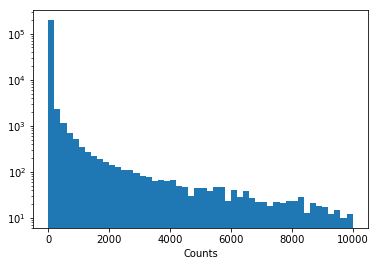

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token in token_counts if token_counts[token] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {token : index for index, token in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 813,    9, 2002,   94,  160,  214,   73,  561, 1071, 2061],
        [3162, 1314, 1464,  561, 1588,  282,  377, 8683,   55,  142],
        [ 155,   60,    6,  792,  558, 2133,  561,  155,   60,    6]],
       dtype=int32),
 'Log1pSalary': array([10.085851, 11.082158, 10.126671], dtype=float32),
 'Title': array([[ 925,   94,  160,   15, 4916,   15, 2142, 1914,  360],
        [  79,    6,   88,    1,    1,    1,    1,    1,    1],
        [ 155,   60,    6,    1,    1,    1,    1,    1,    1]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [20]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        s = self.conv1(h)
        s = self.pool1(s)
        s = self.relu(s)
        return self.dense(s)

In [21]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [22]:
DescEncoder_t = TitleEncoder

In [23]:
desc_encoder = DescEncoder_t(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [24]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder_t(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Sequential(
            nn.Linear(64 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_layers(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [25]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [27]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [28]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [29]:
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
    for start in range(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [30]:
num_epochs = 50
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [31]:
for epoch_i in tqdm_notebook(range(num_epochs)):
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()[0]
        train_mae += compute_mae(reference, prediction).data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()[0]
        val_mae += compute_mae(reference, prediction).data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

A Jupyter Widget

Training:
	Loss:	7.77520
	MAE:	69510.13540



Validation:
	Loss:	0.55447
	MAE:	7230.82631



Training:
	Loss:	1.01973
	MAE:	11582.76323



Validation:
	Loss:	0.41566
	MAE:	6732.49415



Training:
	Loss:	0.90321
	MAE:	10614.36748



Validation:
	Loss:	0.35741
	MAE:	4980.45282



Training:
	Loss:	0.80900
	MAE:	9844.43749



Validation:
	Loss:	0.30331
	MAE:	4856.71473



Training:
	Loss:	0.75939
	MAE:	9171.96485



Validation:
	Loss:	0.26791
	MAE:	4900.86235



Training:
	Loss:	0.74258
	MAE:	9612.69776



Validation:
	Loss:	0.25706
	MAE:	4877.59948



Training:
	Loss:	0.73126
	MAE:	9392.88422



Validation:
	Loss:	0.29982
	MAE:	4580.09860



Training:
	Loss:	0.73087
	MAE:	9356.96122



Validation:
	Loss:	0.25586
	MAE:	4412.04707



Training:
	Loss:	0.72098
	MAE:	9205.78855



Validation:
	Loss:	0.21532
	MAE:	4463.10332



Training:
	Loss:	0.69105
	MAE:	9377.97638



Validation:
	Loss:	0.30668
	MAE:	4709.42214



Training:
	Loss:	0.69409
	MAE:	9022.67703



Validation:
	Loss:	0.19588
	MAE:

In [32]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.13225
	MAE:	3739.61105





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

### GlobalMaxPooling used above

### Adding BatchNorm and DropOut

In [33]:
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(out_size)
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        s = self.conv1(h)
        s = self.dropout(s)
        s = self.pool1(s)
        s = self.relu(s)
        s = self.batchnorm(s)
        return self.dense(s)

In [34]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        self.cat_layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.output = nn.Sequential(
            nn.Linear(64 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        cat_h = self.cat_layers(cat_features)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        out = self.output(joint_h)
        return out[:, 0]

In [35]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

In [36]:
for epoch_i in tqdm_notebook(range(num_epochs)):
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()[0]
        train_mae += compute_mae(reference, prediction).data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()[0]
        val_mae += compute_mae(reference, prediction).data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

A Jupyter Widget

Training:
	Loss:	15.19583
	MAE:	1257618.24384



Validation:
	Loss:	2.00801
	MAE:	39398.04002



Training:
	Loss:	1.21595
	MAE:	13882.54184



Validation:
	Loss:	0.44353
	MAE:	6500.58815



Training:
	Loss:	0.76117
	MAE:	9949.69441



Validation:
	Loss:	0.30767
	MAE:	5919.87003



Training:
	Loss:	0.67426
	MAE:	8949.19629



Validation:
	Loss:	0.26627
	MAE:	4688.68951



Training:
	Loss:	0.67526
	MAE:	9101.69582



Validation:
	Loss:	0.40852
	MAE:	8092.00354



Training:
	Loss:	0.59893
	MAE:	8491.94333



Validation:
	Loss:	0.25441
	MAE:	5442.78608



Training:
	Loss:	0.58121
	MAE:	7945.98024



Validation:
	Loss:	0.20751
	MAE:	4253.28805



Training:
	Loss:	0.55859
	MAE:	7997.73242



Validation:
	Loss:	0.21680
	MAE:	4265.42507



Training:
	Loss:	0.59450
	MAE:	8282.85734



Validation:
	Loss:	0.18594
	MAE:	4169.42135



Training:
	Loss:	0.54373
	MAE:	7894.68899



Validation:
	Loss:	0.17721
	MAE:	4062.29752



Training:
	Loss:	0.59712
	MAE:	8414.98264



Validation:
	Loss:	0.31700
	M

In [37]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.11027
	MAE:	3173.23654





##### Видим некоторые улучшения после вставки DropOut и BatchNorm MAE 3739.61105 -> 3173.23654

### Adding Parallel convolution layers

In [41]:
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool2 = GlobalMaxPooling() 
        self.relu2 = nn.ReLU()
        
        self.dense = nn.Linear(2 * out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        
        s1 = self.conv1(h)
        s1 = self.pool1(s1)
        s1 = self.relu1(s1)

        s2 = self.conv2(h)
        s2 = self.pool2(s2)
        s2 = self.relu2(s2)
        
        return self.dense(torch.cat([s1, s2], dim=1))

In [42]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        self.cat_layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.output = nn.Sequential(
            nn.Linear(64 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        cat_h = self.cat_layers(cat_features)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        out = self.output(joint_h)
        return out[:, 0]

In [43]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

In [44]:
for epoch_i in tqdm_notebook(range(num_epochs)):
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()[0]
        train_mae += compute_mae(reference, prediction).data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()[0]
        val_mae += compute_mae(reference, prediction).data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

A Jupyter Widget

Training:
	Loss:	8.29843
	MAE:	73580.83904



Validation:
	Loss:	0.56532
	MAE:	7496.94072



Training:
	Loss:	1.04723
	MAE:	11702.90706



Validation:
	Loss:	0.40340
	MAE:	5255.88726



Training:
	Loss:	0.94826
	MAE:	10840.82919



Validation:
	Loss:	0.41049
	MAE:	7498.00214



Training:
	Loss:	0.77080
	MAE:	9621.19995



Validation:
	Loss:	0.31016
	MAE:	4738.21165



Training:
	Loss:	0.75123
	MAE:	9536.60485



Validation:
	Loss:	0.27309
	MAE:	5106.21598



Training:
	Loss:	0.75764
	MAE:	9985.49946



Validation:
	Loss:	0.26378
	MAE:	4440.51031



Training:
	Loss:	0.69832
	MAE:	9136.23265



Validation:
	Loss:	0.23693
	MAE:	4726.39720



Training:
	Loss:	0.72183
	MAE:	9319.54320



Validation:
	Loss:	0.25863
	MAE:	4298.63661



Training:
	Loss:	0.67580
	MAE:	9216.80600



Validation:
	Loss:	0.23437
	MAE:	4997.43944



Training:
	Loss:	0.71595
	MAE:	9244.49377



Validation:
	Loss:	0.25358
	MAE:	5601.62829



Training:
	Loss:	0.68094
	MAE:	8981.67970



Validation:
	Loss:	0.39114
	MAE:

In [45]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.14009
	MAE:	3922.36623





##### Видим ухудшение после  Parallel convolution layers MAE 3739.61105 -> 3922.36623

### Adding Plotting learning curves and Early stopping

In [127]:
from matplotlib import pyplot as plt

def plotting(loss_train, loss_val, MAE_train, MAE_val, epoch):
    if epoch > 2:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(30, 10)

        ax1.plot(loss_train, label='loss_train')
        ax1.plot(loss_val, label='loss_val')
        ax1.legend()
        ax1.set_xlabel('iterations')
        ax1.set_ylabel('Loss')

        ax2.plot(MAE_train, label='MAE_train')
        ax2.plot(MAE_val, label='MAE_val')
        ax2.legend()
        ax2.set_xlabel('iterations')
        ax2.set_ylabel('MAE')
        plt.show()
    
def EarlyStopping(loss, epoch, stopping_flag=0.05):
    if epoch < 10:
        return False
    eval_loss_diff = 1 - loss[-1] / loss[-5]
    if eval_loss_diff < stopping_flag:
        print("Evaluation loss stopped decreased less than {}. Early stopping at epoch {}.".\
              format(stopping_flag, epoch))
        return True
    return False

In [128]:
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(out_size)
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        s = self.conv1(h)
        s = self.dropout(s)
        s = self.pool1(s)
        s = self.relu(s)
        s = self.batchnorm(s)
        return self.dense(s)

In [129]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        self.cat_layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.output = nn.Sequential(
            nn.Linear(64 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        cat_h = self.cat_layers(cat_features)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        out = self.output(joint_h)
        return out[:, 0]

In [130]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

A Jupyter Widget

Training:

	Loss:	16.82664
	MAE:	440317.71115



Validation:
	Loss:	1.41813
	MAE:	23675.29595



Training:
	Loss:	1.23422
	MAE:	14792.57980



Validation:
	Loss:	0.57949
	MAE:	10016.94158



Training:
	Loss:	0.75806
	MAE:	9680.66690



Validation:
	Loss:	0.36658
	MAE:	7150.80410



Training:
	Loss:	0.68614
	MAE:	9231.57150



Validation:
	Loss:	0.36521
	MAE:	5108.47002





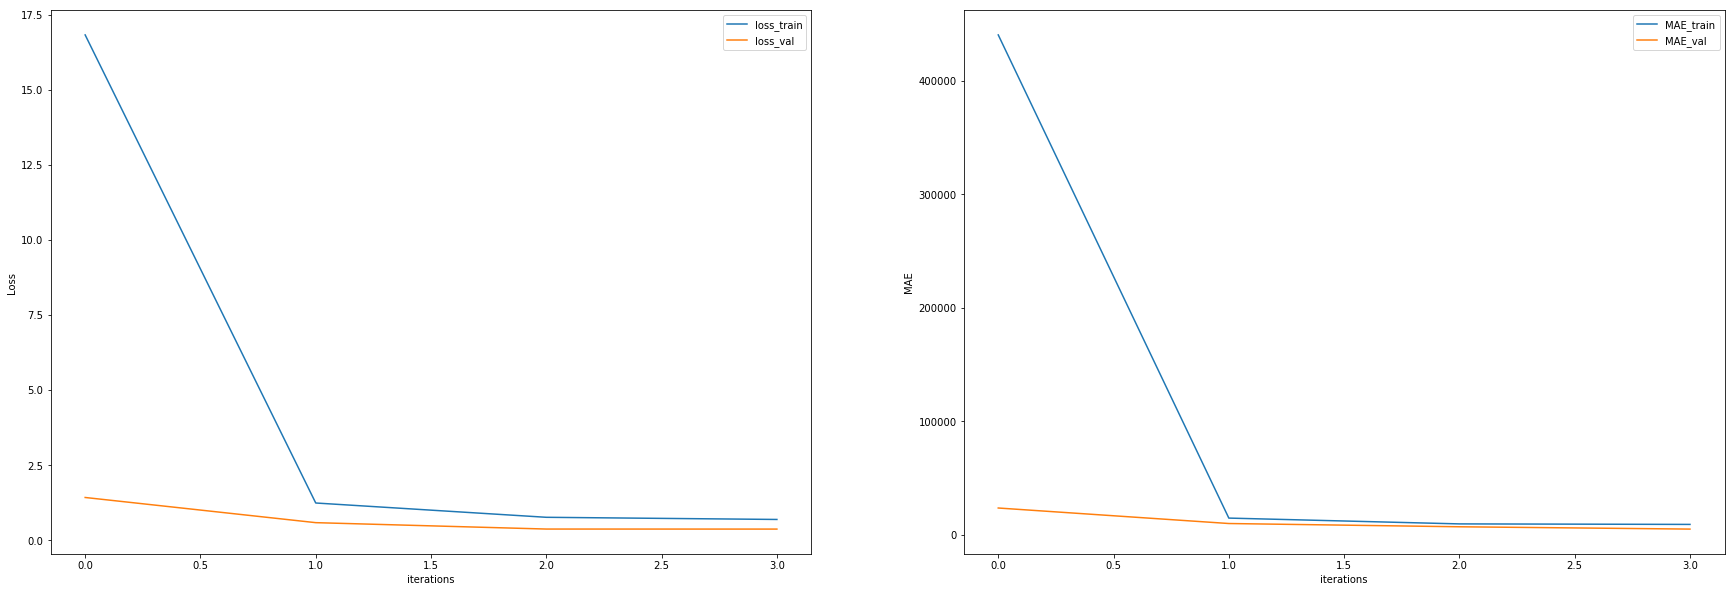

Training:
	Loss:	0.64923
	MAE:	8856.15371



Validation:
	Loss:	0.24528
	MAE:	4547.25792





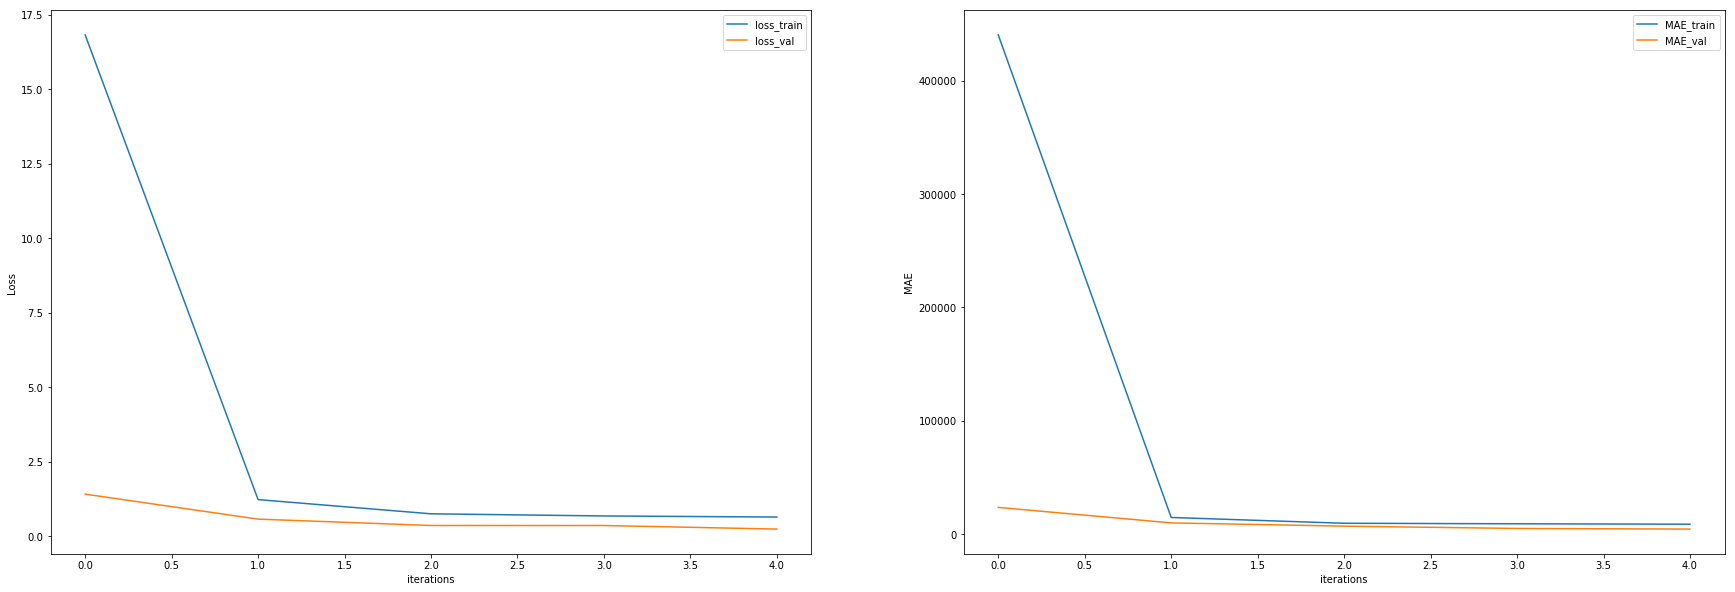

Training:
	Loss:	0.62963
	MAE:	8497.17926



Validation:
	Loss:	0.33243
	MAE:	6719.31439





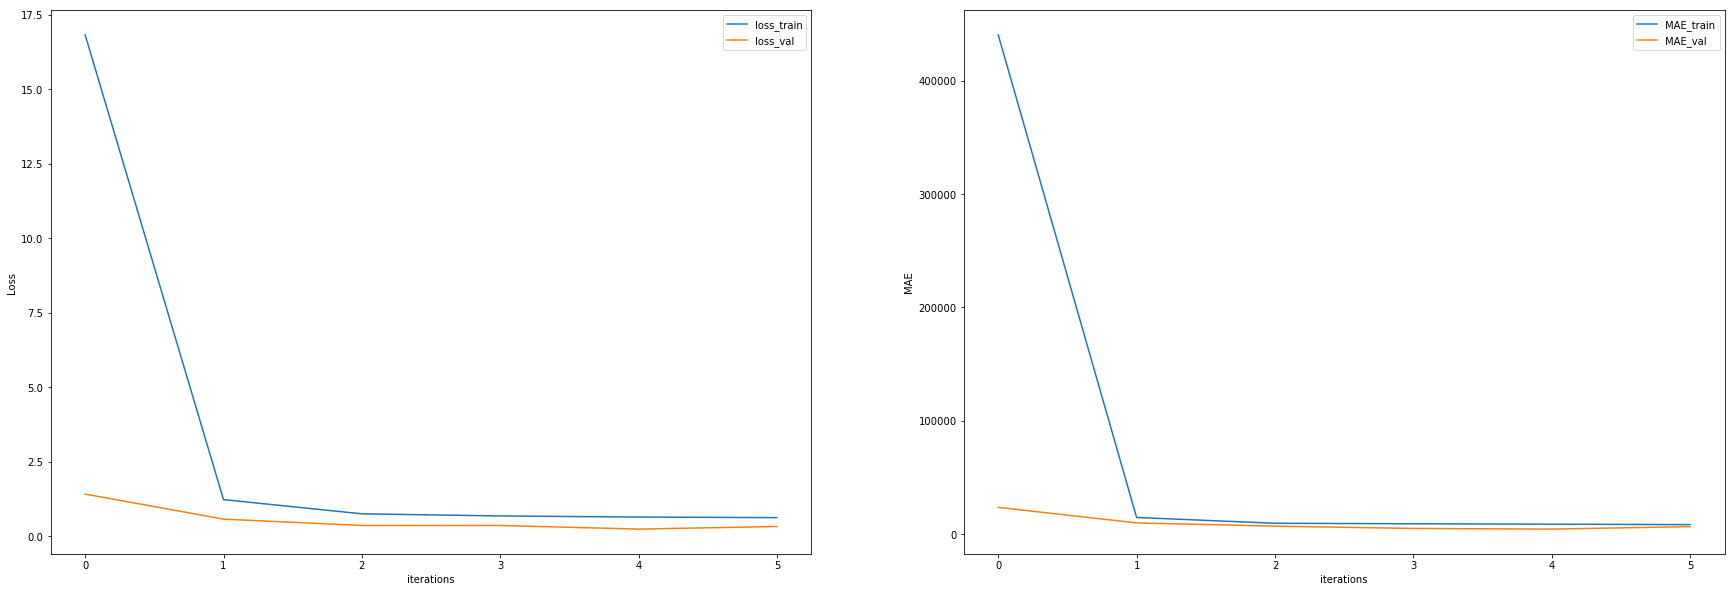

Training:
	Loss:	0.64299
	MAE:	8570.80657



Validation:
	Loss:	0.27569
	MAE:	4556.19089





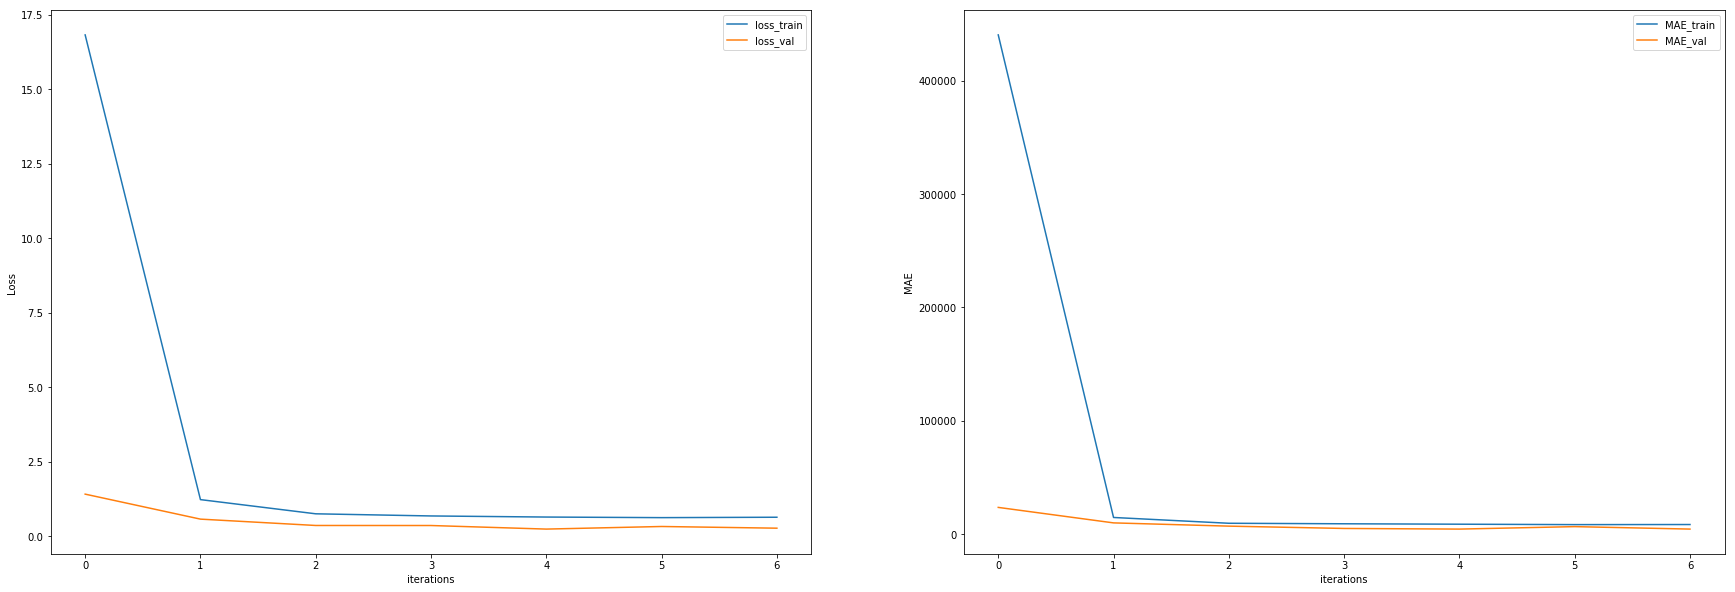

Training:
	Loss:	0.61402
	MAE:	8723.06276



Validation:
	Loss:	0.48690
	MAE:	5809.93118





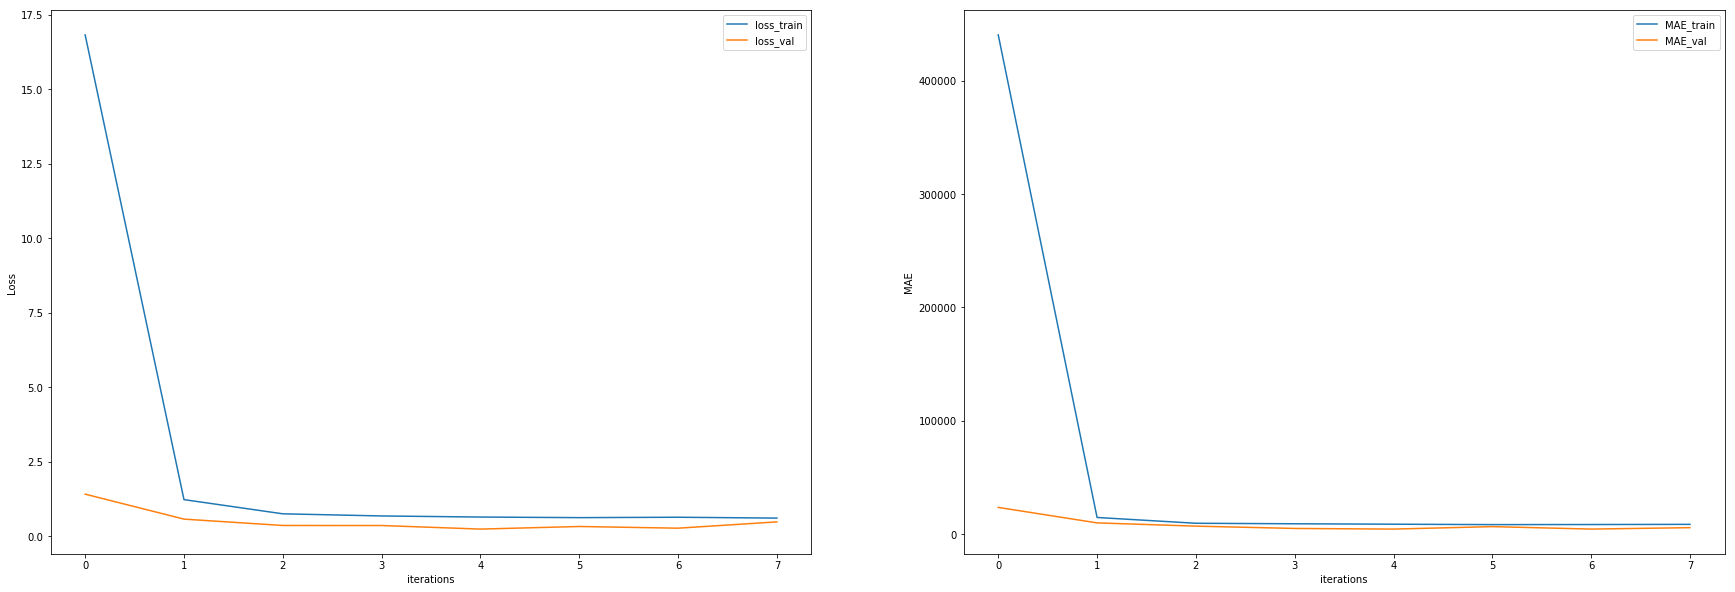

Training:
	Loss:	0.62931
	MAE:	8394.01536



Validation:
	Loss:	0.37107
	MAE:	7350.56073





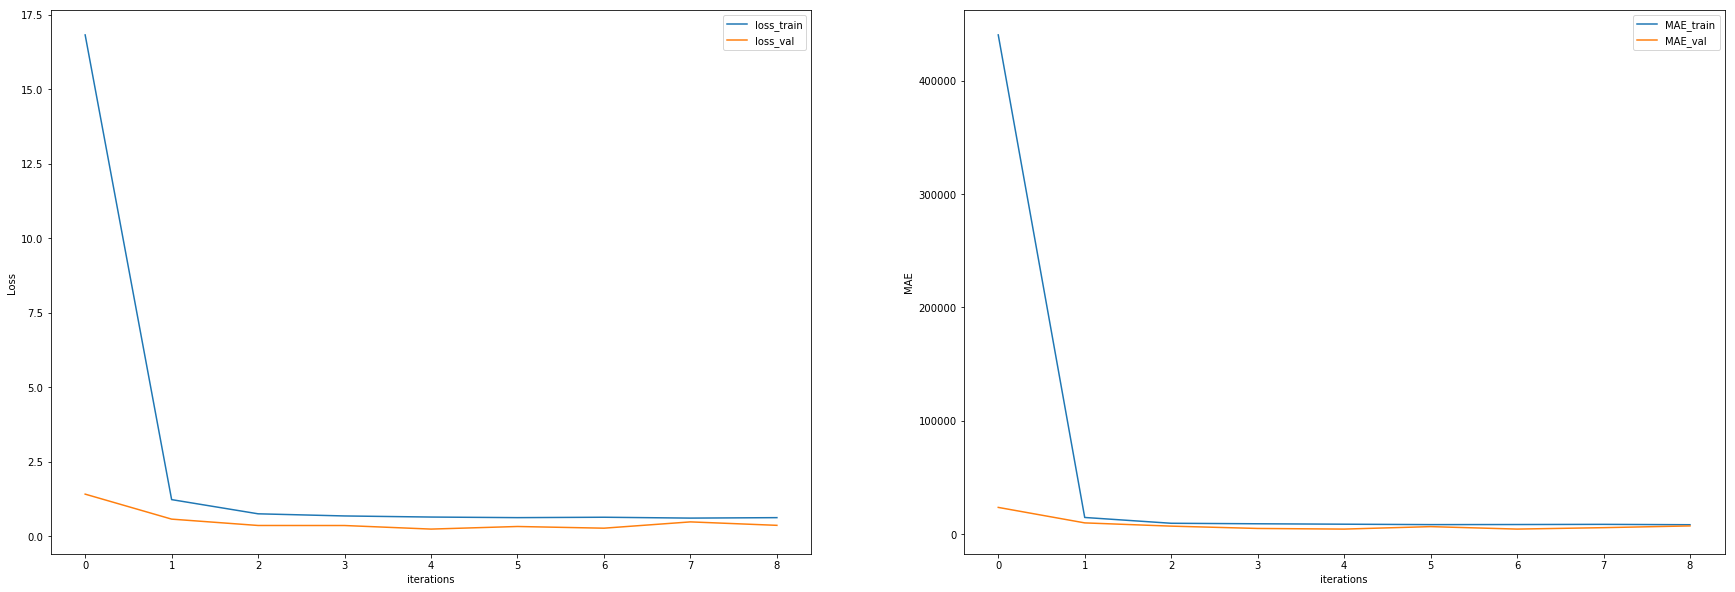

Training:
	Loss:	0.60119
	MAE:	8503.68652



Validation:
	Loss:	0.20690
	MAE:	4153.53268





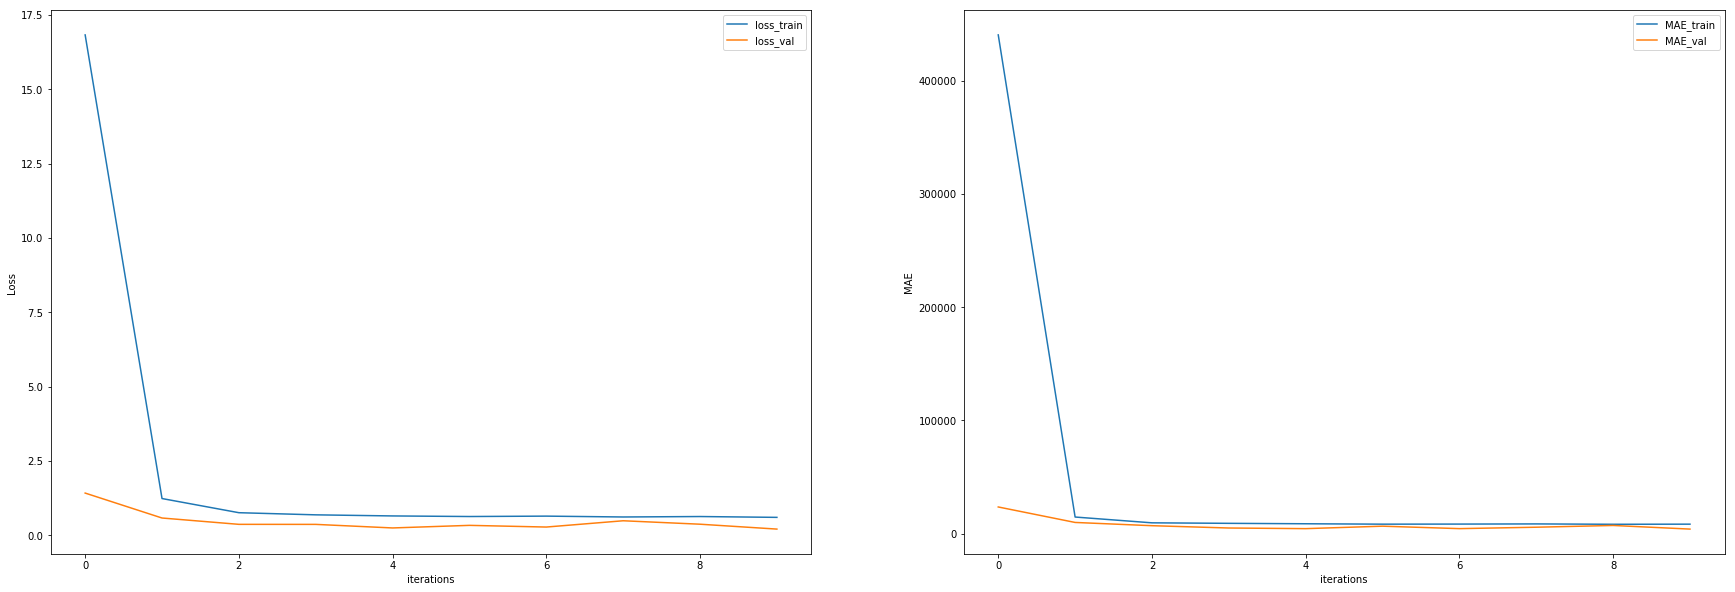

Training:
	Loss:	0.57023
	MAE:	8190.84855



Validation:
	Loss:	0.27412
	MAE:	4529.06197





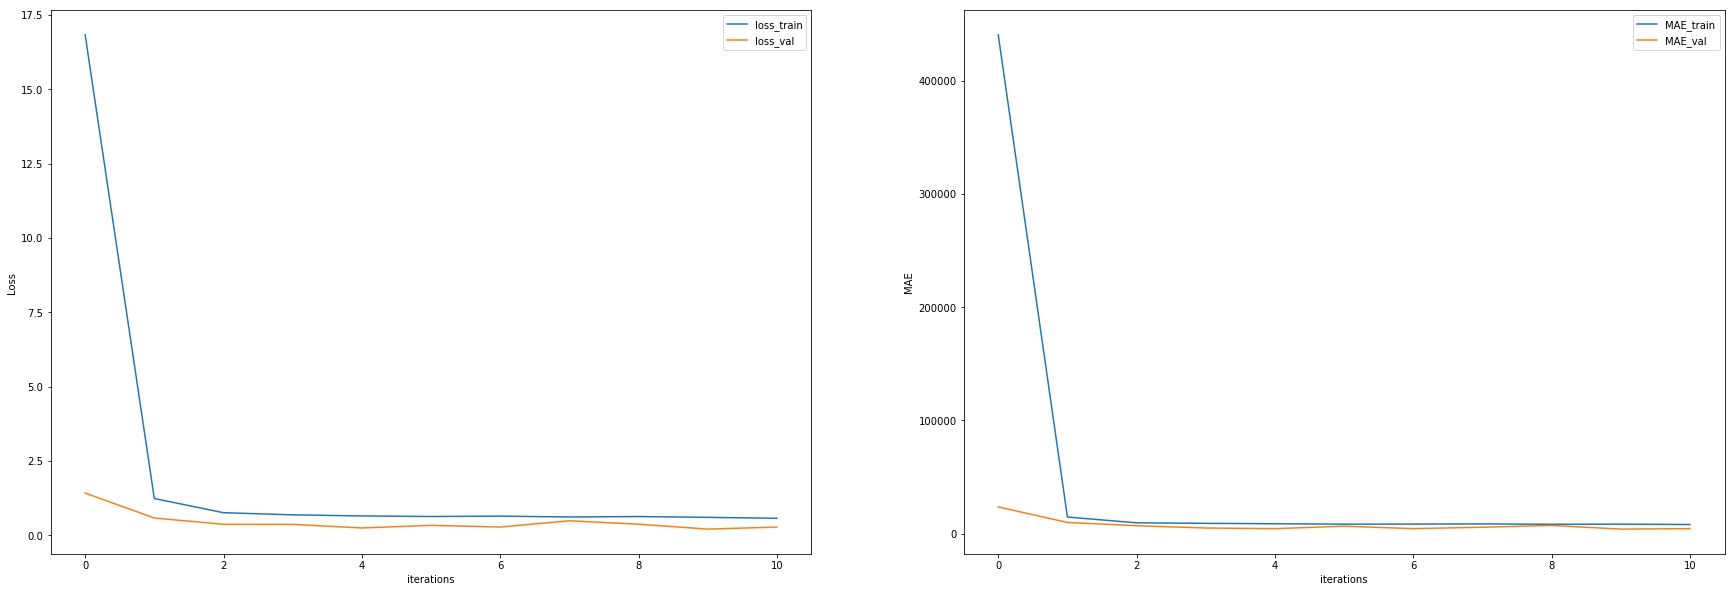

Evaluation loss stopped decreased less than 0.05. Early stopping at epoch 10.


In [131]:
loss_train, loss_val, MAE_train, MAE_val = [], [], [], []


for epoch_i in tqdm_notebook(range(num_epochs)):
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()[0]
        train_mae += compute_mae(reference, prediction).data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()[0]
        val_mae += compute_mae(reference, prediction).data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
    loss_train.append(train_loss / train_batches)
    loss_val.append(val_loss / val_batches)
    MAE_train.append(train_mae / train_batches)
    MAE_val.append(val_mae / val_batches)
    
    plotting(loss_train, loss_val, MAE_train, MAE_val, epoch_i)
    
    if EarlyStopping(loss=loss_val, epoch=epoch_i):
        break

In [133]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.27412
	MAE:	4529.06197





##### loss понижается не монотонно, поэтому применим сглаживание

In [175]:
def EarlyStopping_Smooth(loss, epoch, stopping_flag=0.0):
    if epoch < 10:
        return False
    eval_loss_diff = 1 - np.mean(loss[-5:]) / np.mean(loss[-10:-5])
    if eval_loss_diff < stopping_flag:
        print("Evaluation loss stopped decreased less than {} ({}). Early stopping at epoch {}.".\
              format(stopping_flag, 1 - np.mean(loss[-5:]) / np.mean(loss[-10:-5]), epoch))
        return True
    return False

In [176]:
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(out_size)
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        s = self.conv1(h)
        s = self.dropout(s)
        s = self.pool1(s)
        s = self.relu(s)
        s = self.batchnorm(s)
        return self.dense(s)

In [177]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        self.cat_layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.output = nn.Sequential(
            nn.Linear(64 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        cat_h = self.cat_layers(cat_features)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        out = self.output(joint_h)
        return out[:, 0]

In [178]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

A Jupyter Widget

Training:

	Loss:	15.23563
	MAE:	933332.30414



Validation:
	Loss:	2.43765
	MAE:	50491.19557



Training:
	Loss:	1.19402
	MAE:	14080.56182



Validation:
	Loss:	0.52751
	MAE:	9380.29513



Training:
	Loss:	0.77754
	MAE:	9880.81466



Validation:
	Loss:	0.30199
	MAE:	5280.86519



Training:
	Loss:	0.64795
	MAE:	8669.50756



Validation:
	Loss:	0.27186
	MAE:	5410.56823





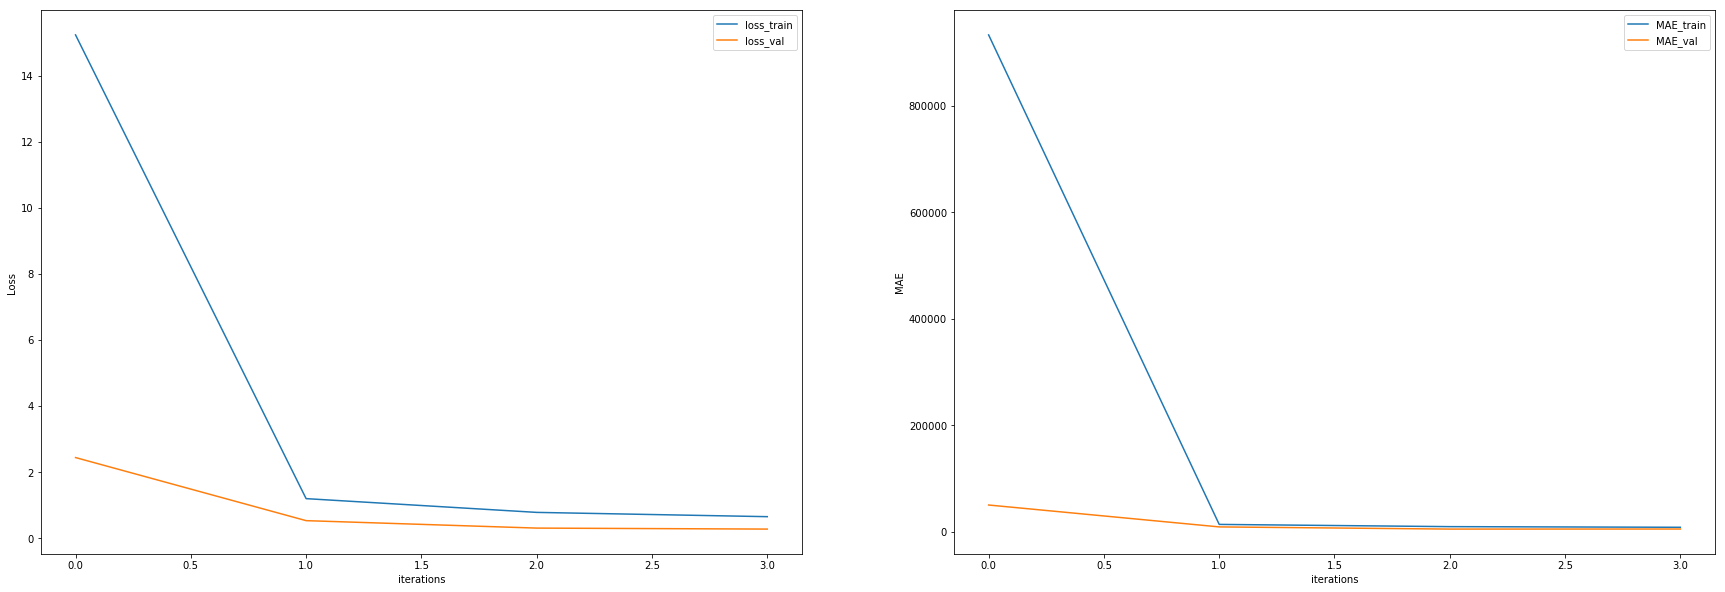

Training:
	Loss:	0.65488
	MAE:	8547.81931



Validation:
	Loss:	0.51381
	MAE:	9874.45750





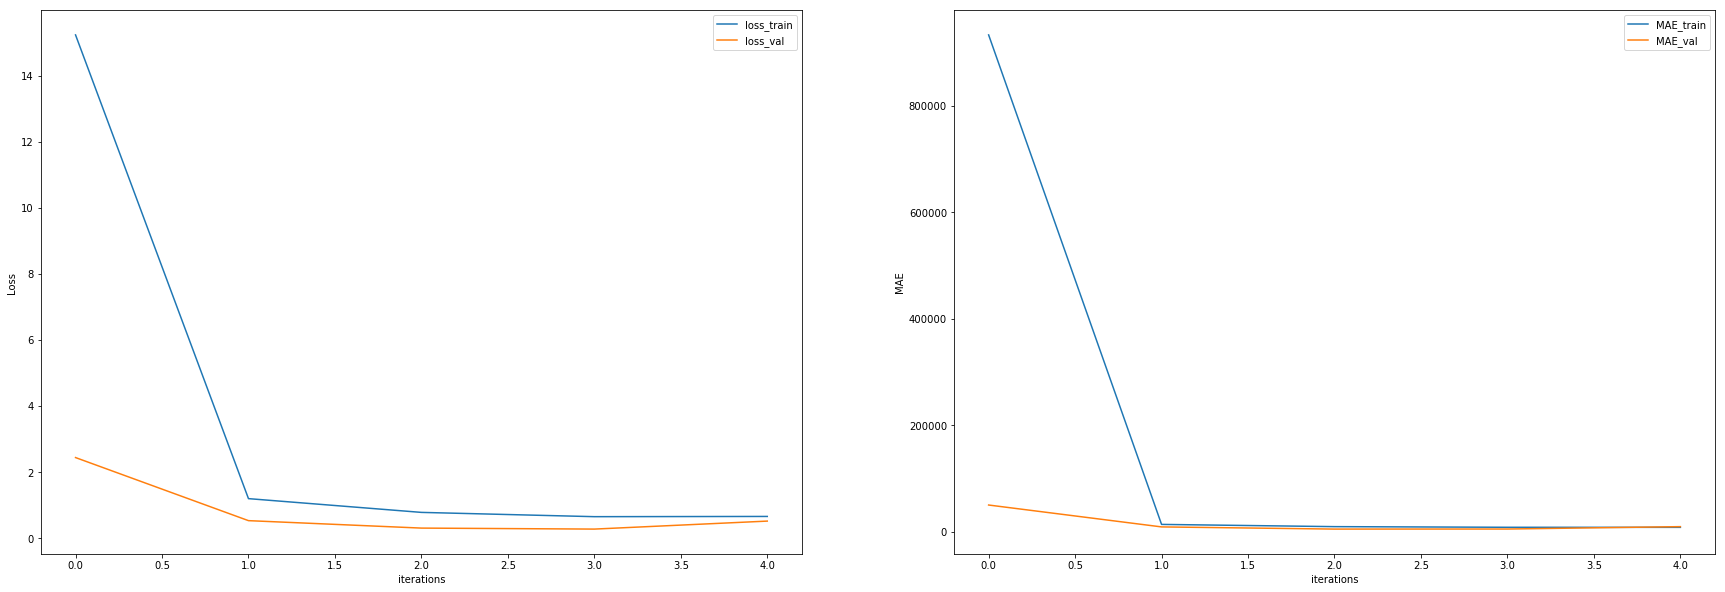

Training:
	Loss:	0.64944
	MAE:	8717.37765



Validation:
	Loss:	0.34491
	MAE:	4952.12903





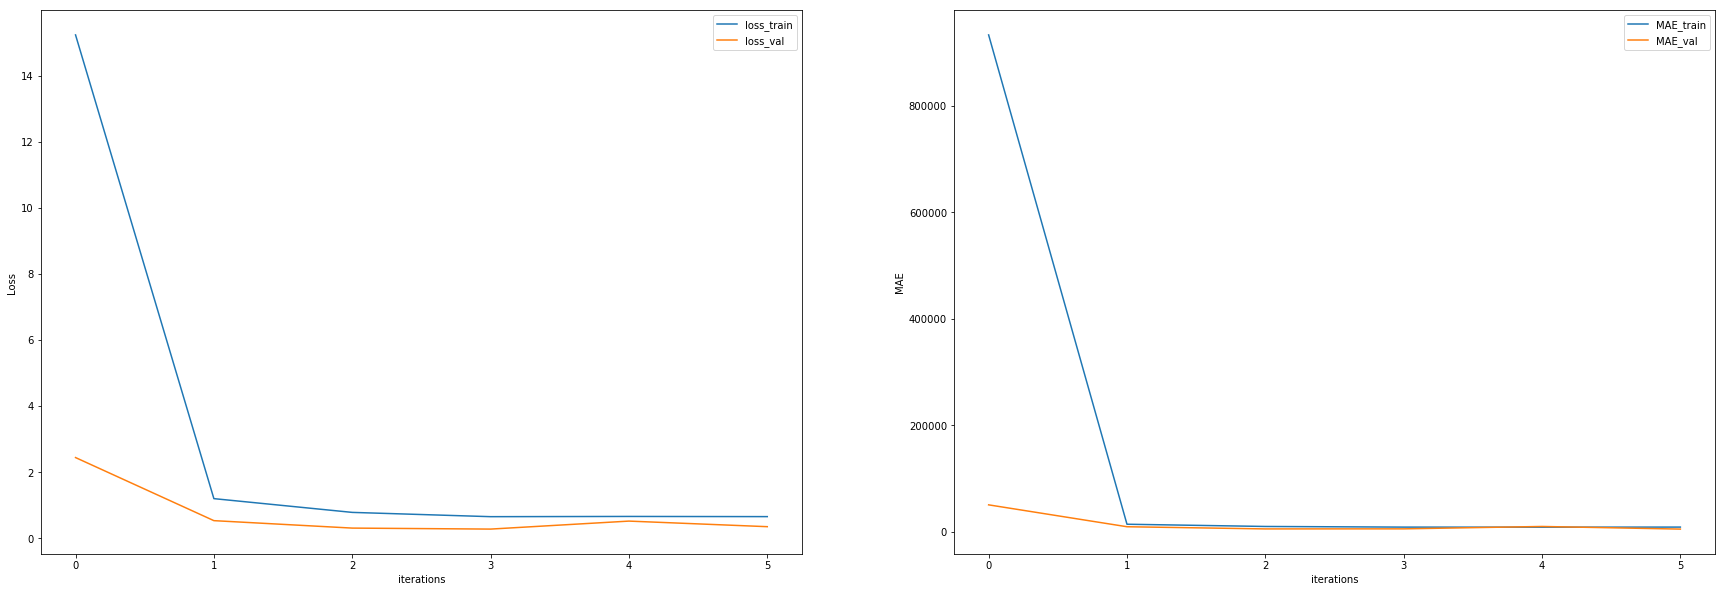

Training:
	Loss:	0.58542
	MAE:	8185.61054



Validation:
	Loss:	0.21373
	MAE:	4439.71087





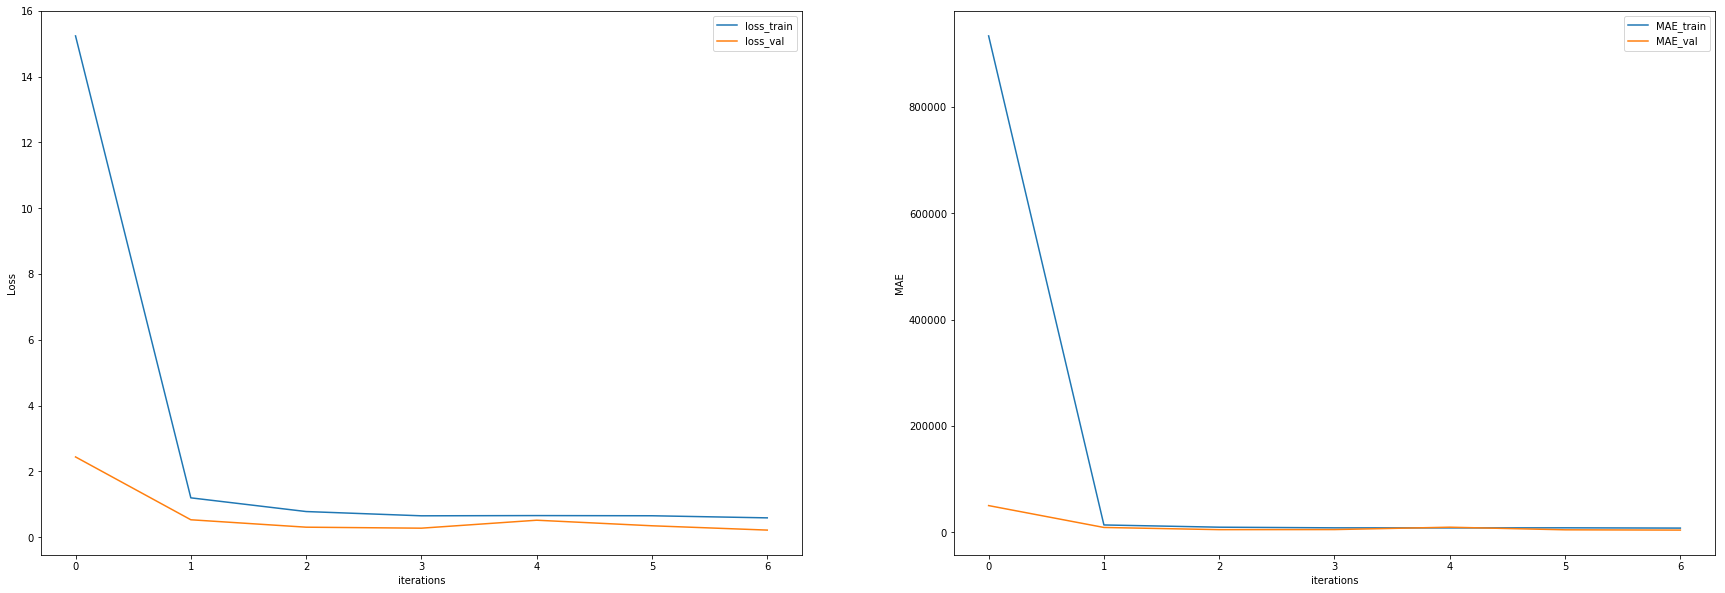

Training:
	Loss:	0.60463
	MAE:	8466.00883



Validation:
	Loss:	0.25895
	MAE:	5659.86840





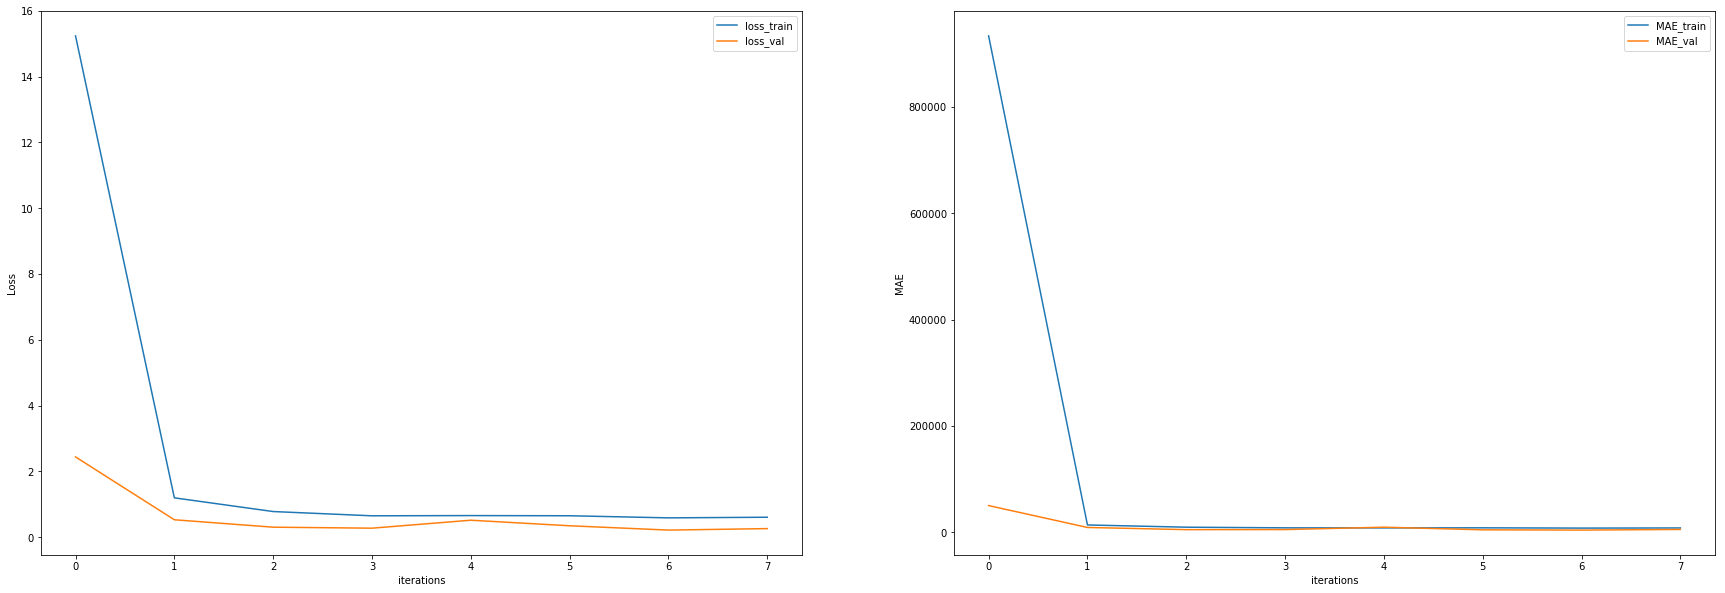

Training:
	Loss:	0.61060
	MAE:	8368.02376



Validation:
	Loss:	0.22753
	MAE:	5089.21078





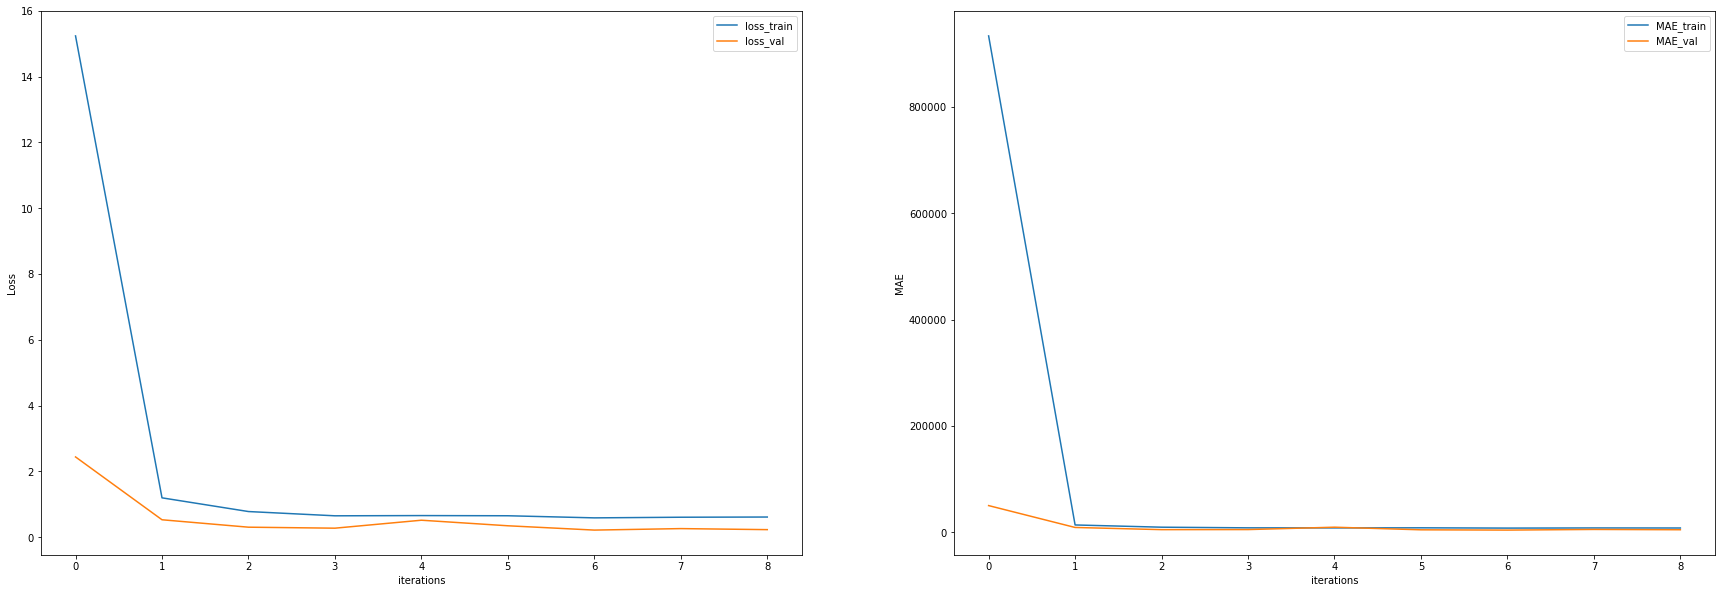

Training:
	Loss:	0.54911
	MAE:	7957.00503



Validation:
	Loss:	0.18492
	MAE:	4287.86415





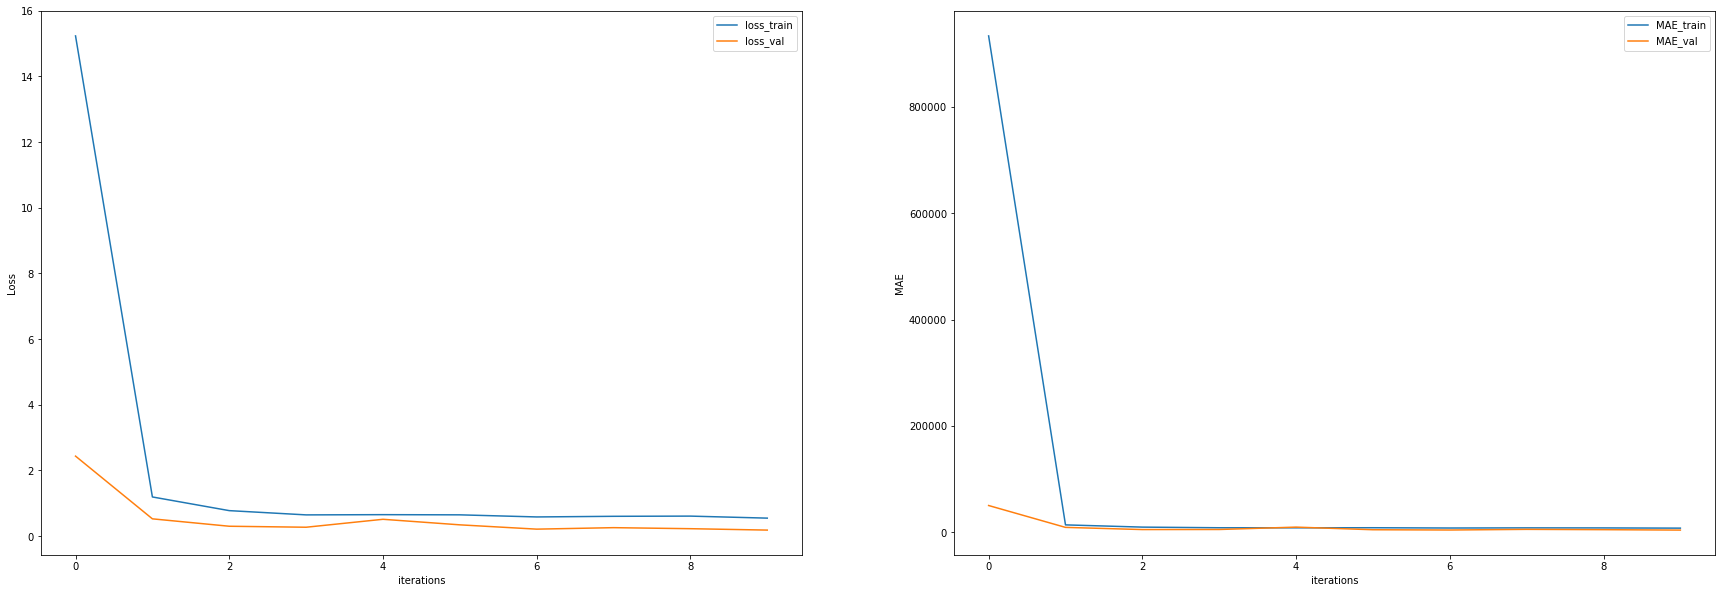

Training:
	Loss:	0.53838
	MAE:	7922.33600



Validation:
	Loss:	0.29898
	MAE:	6343.44283





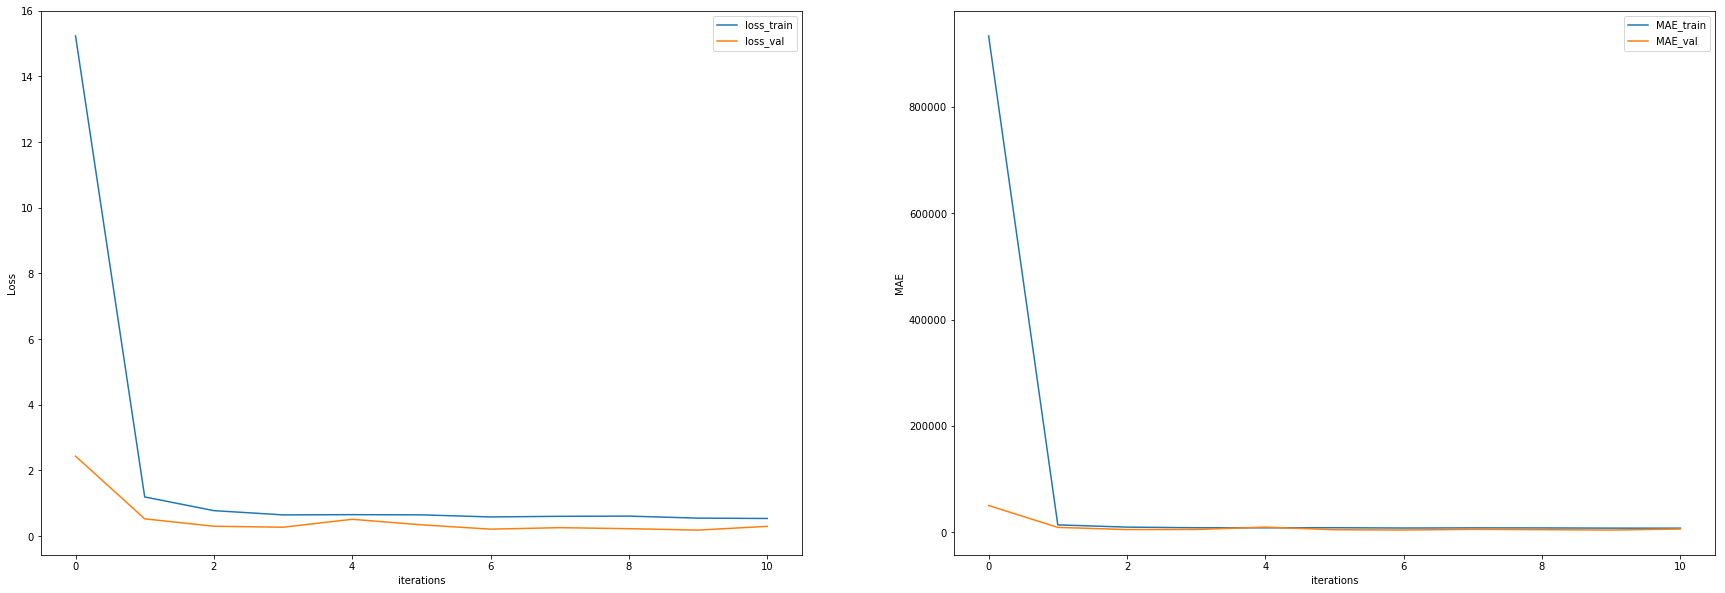

Training:
	Loss:	0.55251
	MAE:	8054.97652



Validation:
	Loss:	0.17616
	MAE:	3980.43302





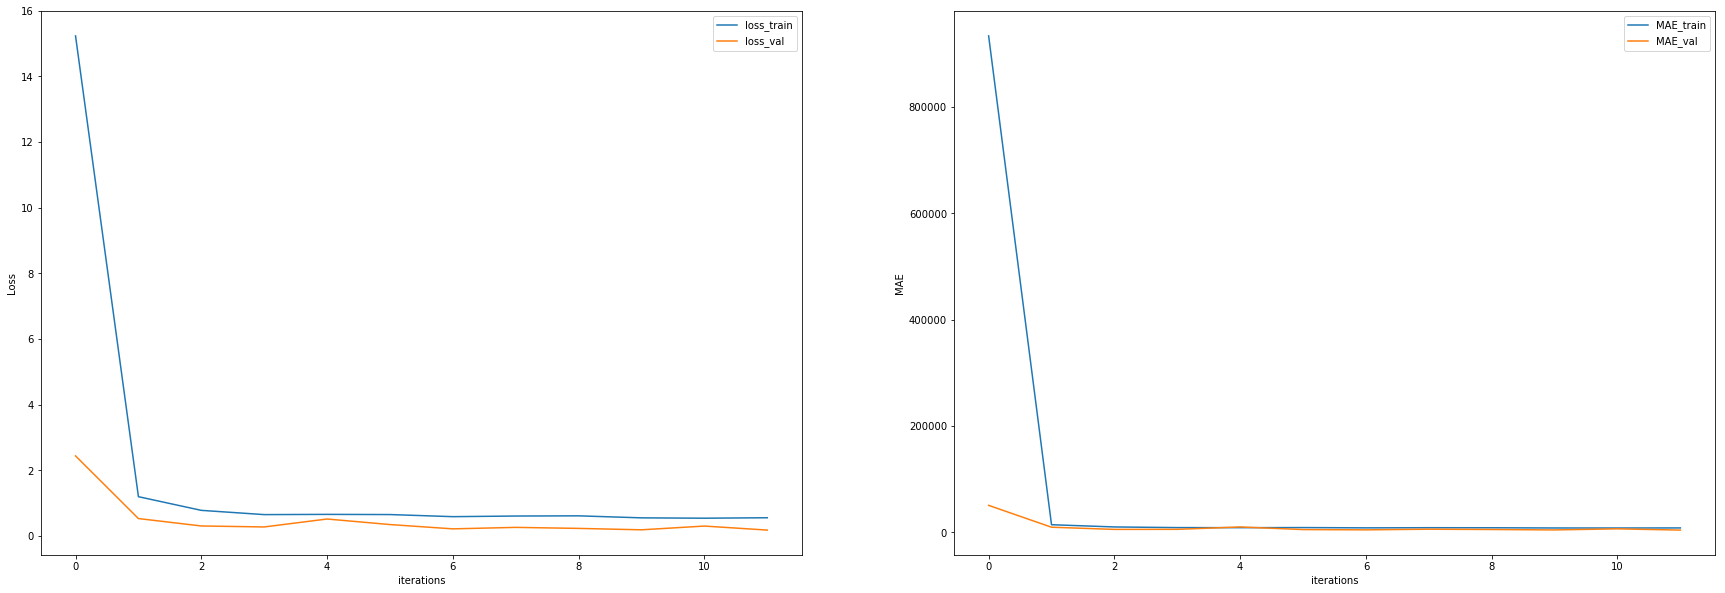

Training:
	Loss:	0.51329
	MAE:	7537.53803



Validation:
	Loss:	0.20247
	MAE:	4111.40037





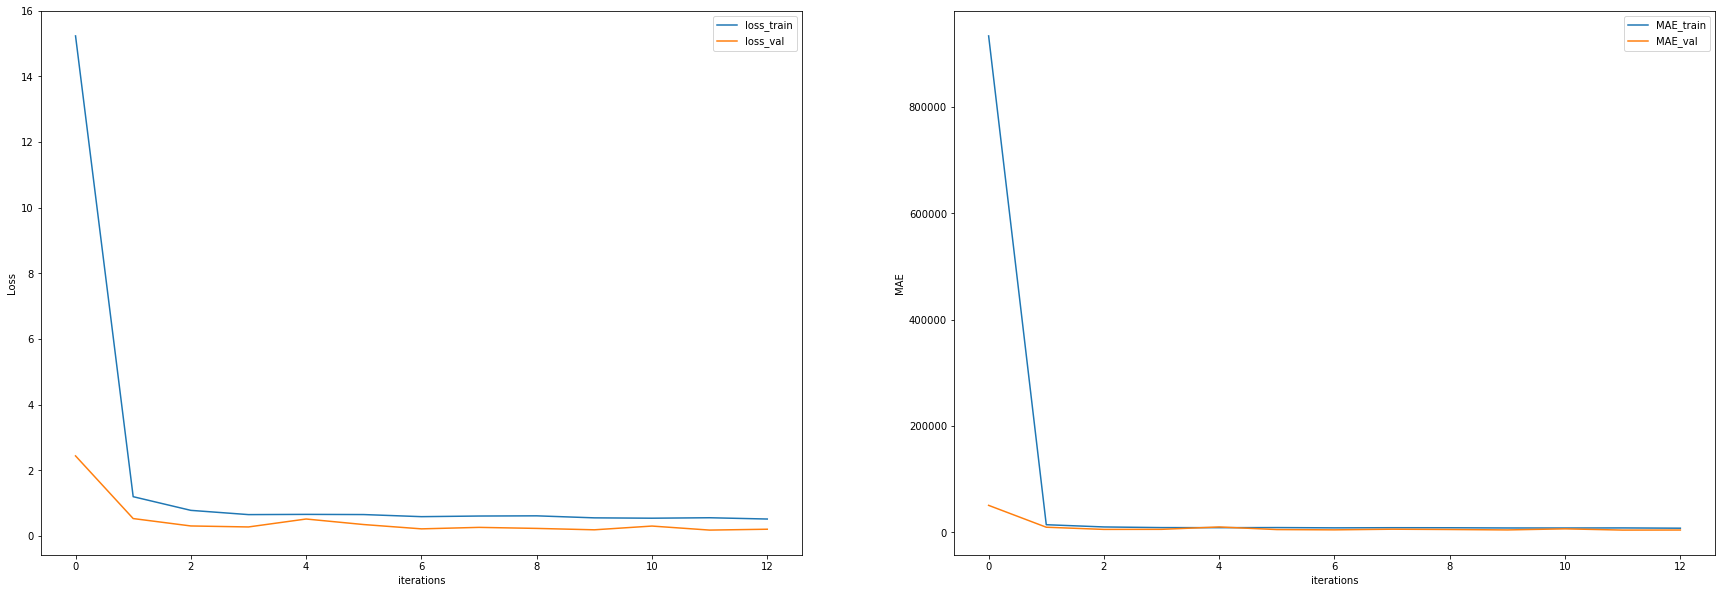

Training:
	Loss:	0.57844
	MAE:	8225.05739



Validation:
	Loss:	0.19104
	MAE:	4046.05364





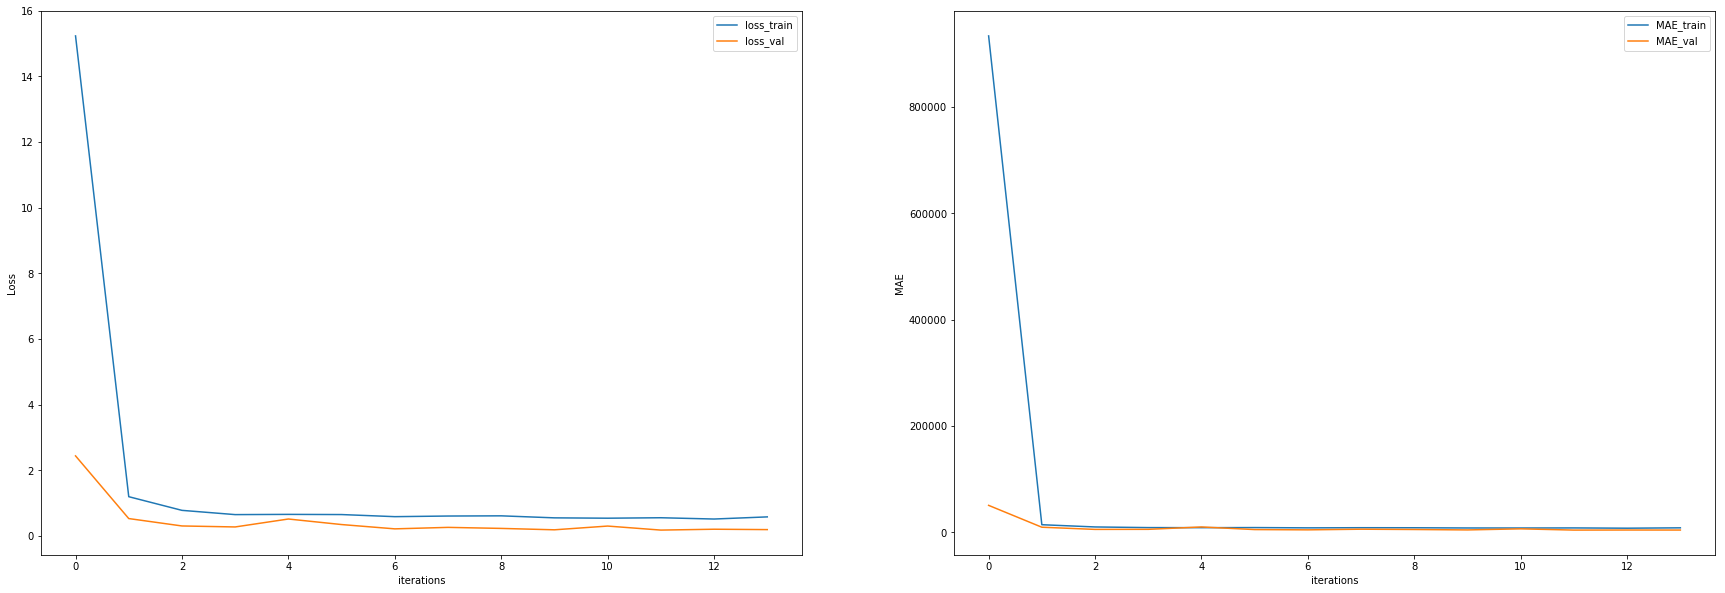

Training:
	Loss:	0.52536
	MAE:	7837.04988



Validation:
	Loss:	0.18226
	MAE:	4361.26615





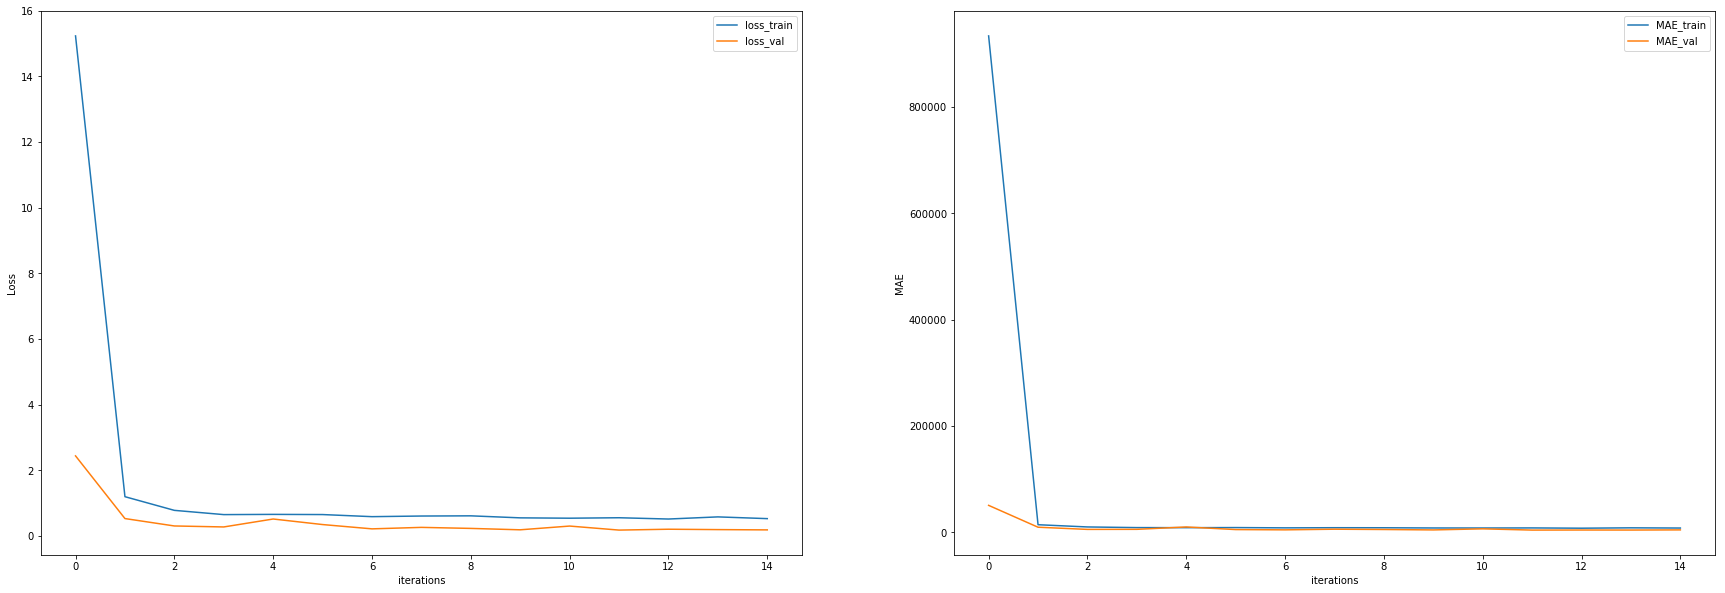

Training:
	Loss:	0.56215
	MAE:	8236.74684



Validation:
	Loss:	0.18329
	MAE:	4431.77195





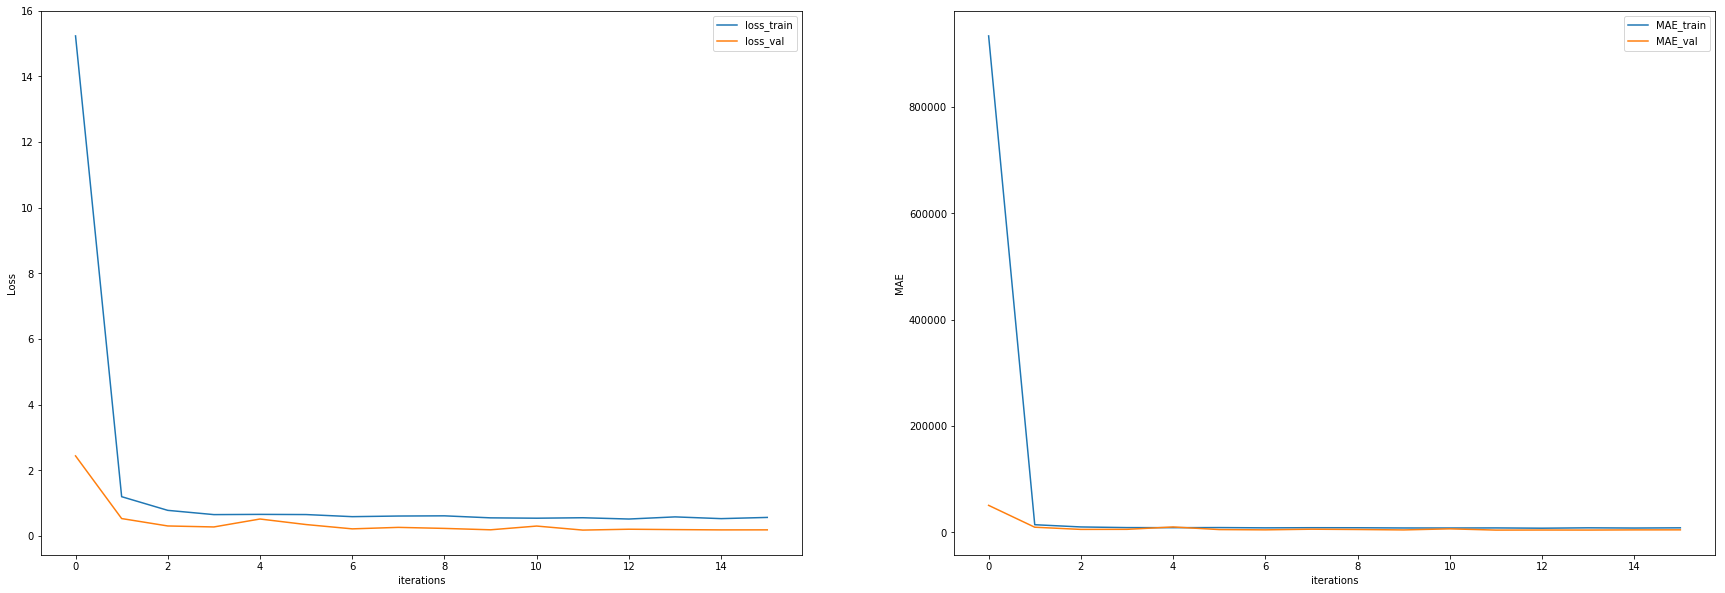

Training:
	Loss:	0.52773
	MAE:	7611.52874



Validation:
	Loss:	0.16270
	MAE:	3759.36550





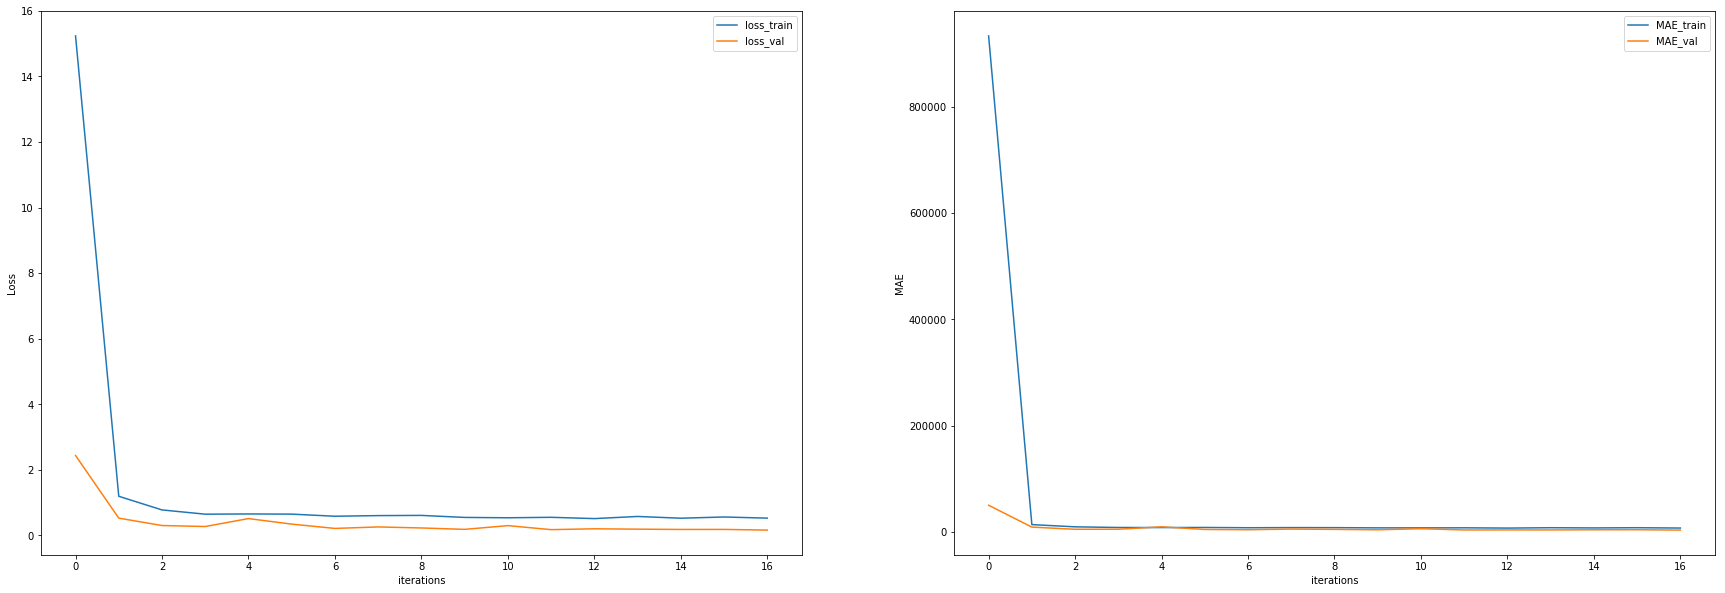

Training:
	Loss:	0.51520
	MAE:	7551.55322



Validation:
	Loss:	0.15286
	MAE:	3728.80515





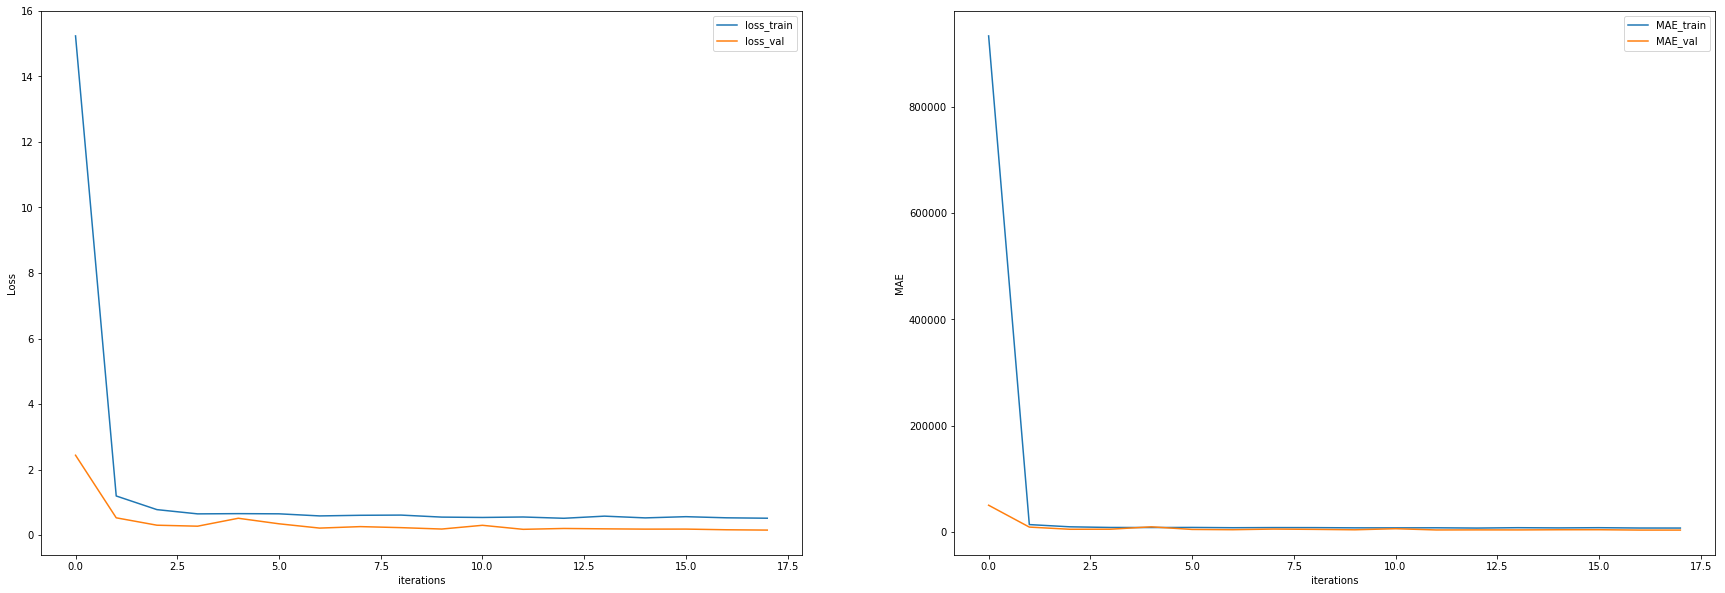

Training:
	Loss:	0.51671
	MAE:	7454.15917



Validation:
	Loss:	0.19423
	MAE:	4017.25485





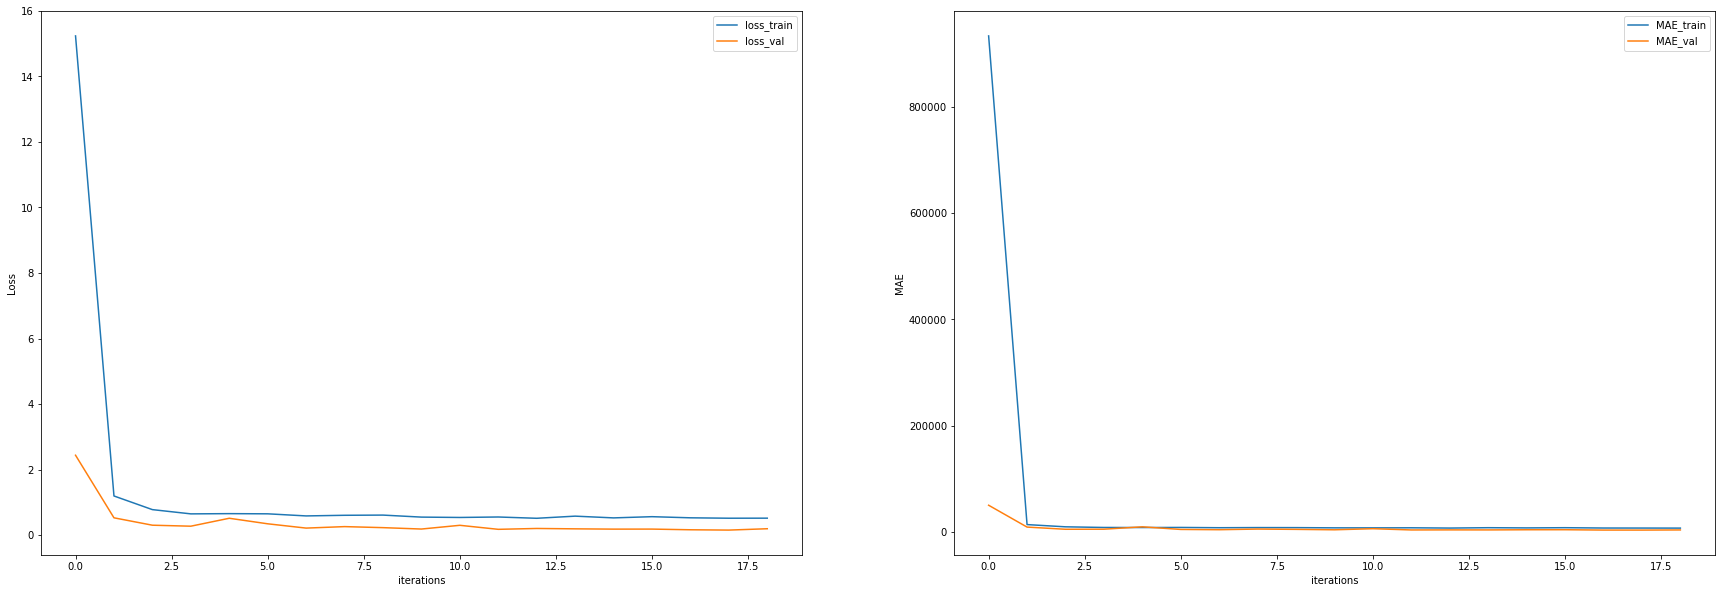

Training:
	Loss:	0.50221
	MAE:	7600.42569



Validation:
	Loss:	0.14362
	MAE:	3618.29691





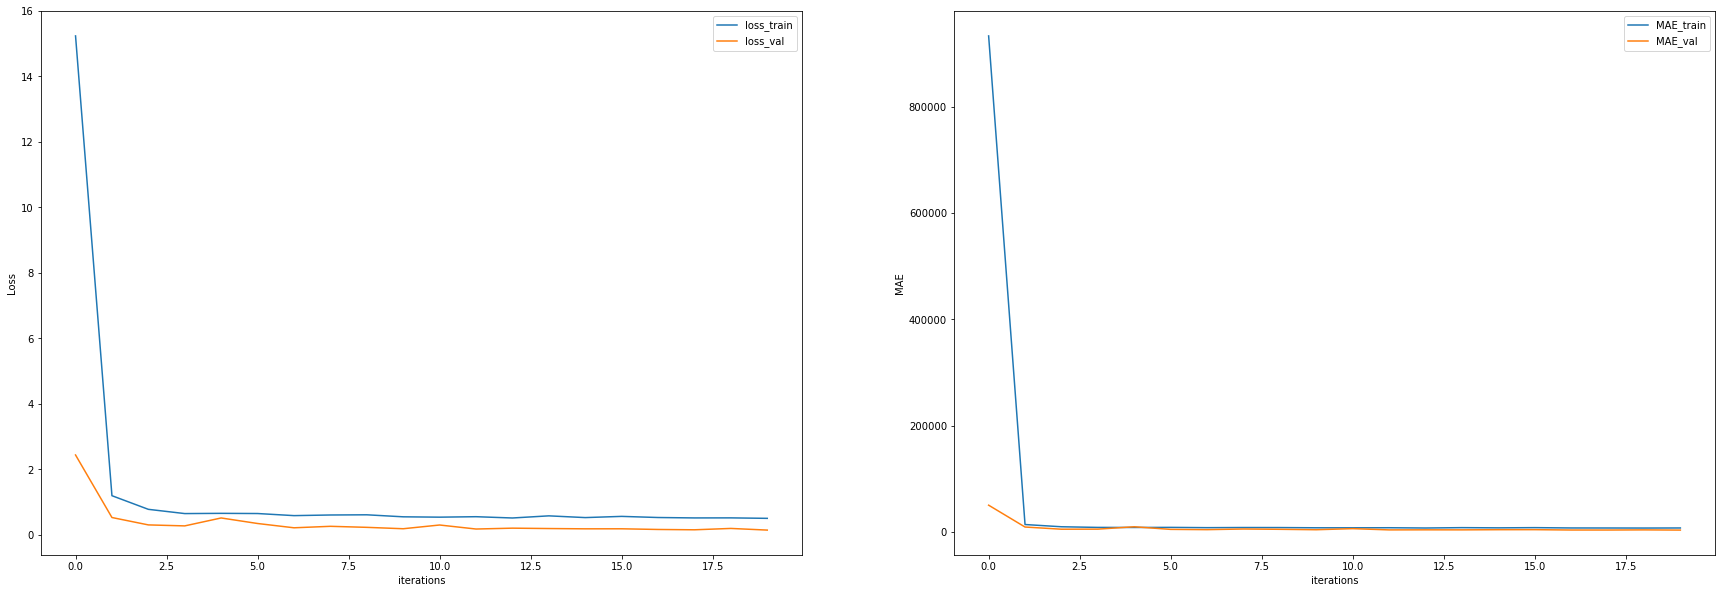

Training:
	Loss:	0.57871
	MAE:	8432.32236



Validation:
	Loss:	0.18764
	MAE:	3972.21632





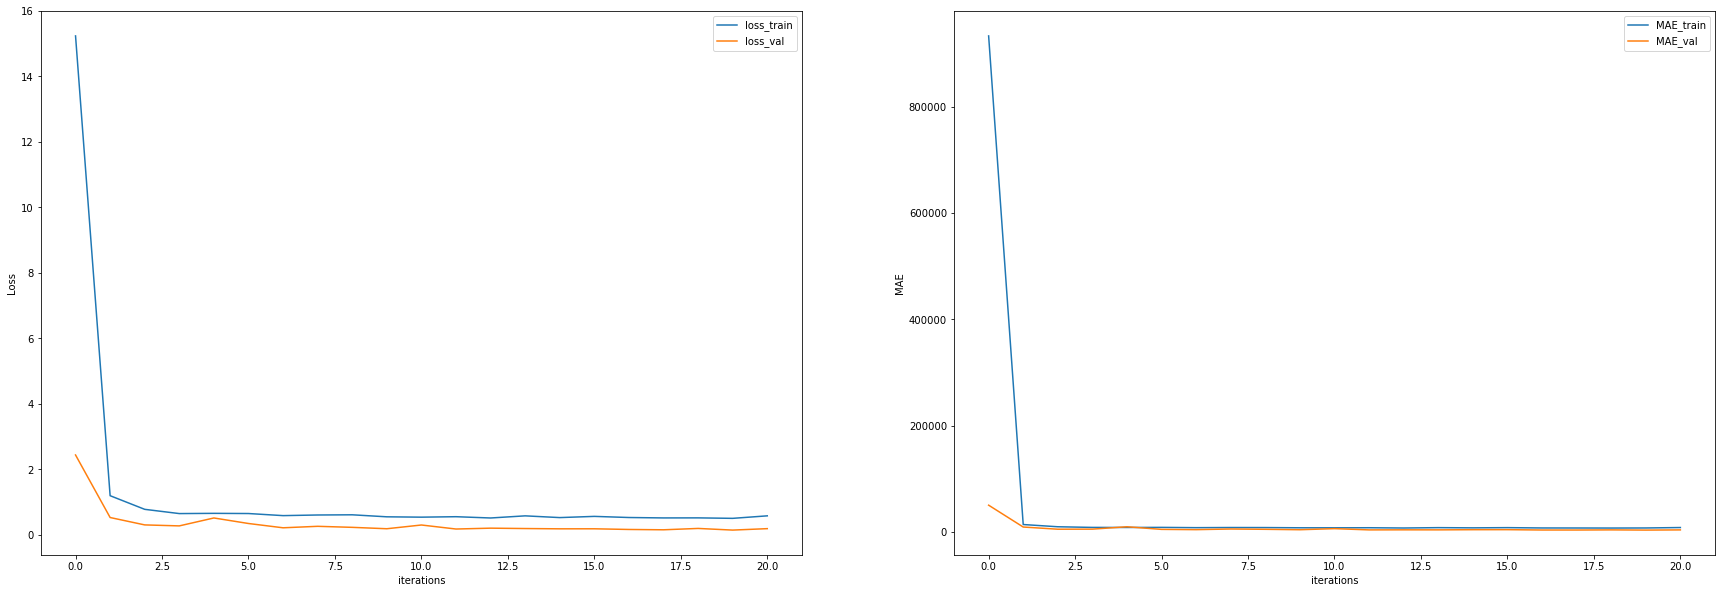

Training:
	Loss:	0.49442
	MAE:	7507.56844



Validation:
	Loss:	0.14529
	MAE:	3619.49536





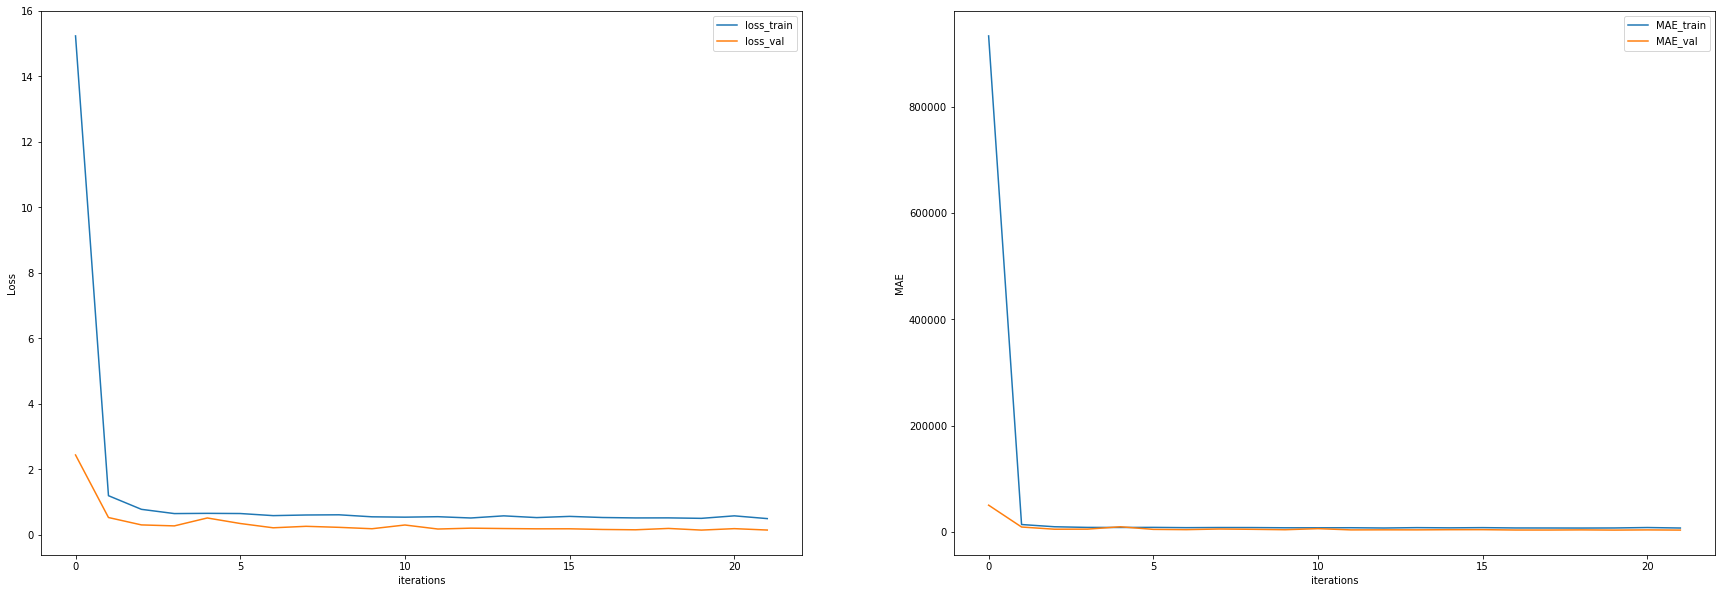

Training:
	Loss:	0.50878
	MAE:	7703.23868



Validation:
	Loss:	0.14099
	MAE:	3617.78147





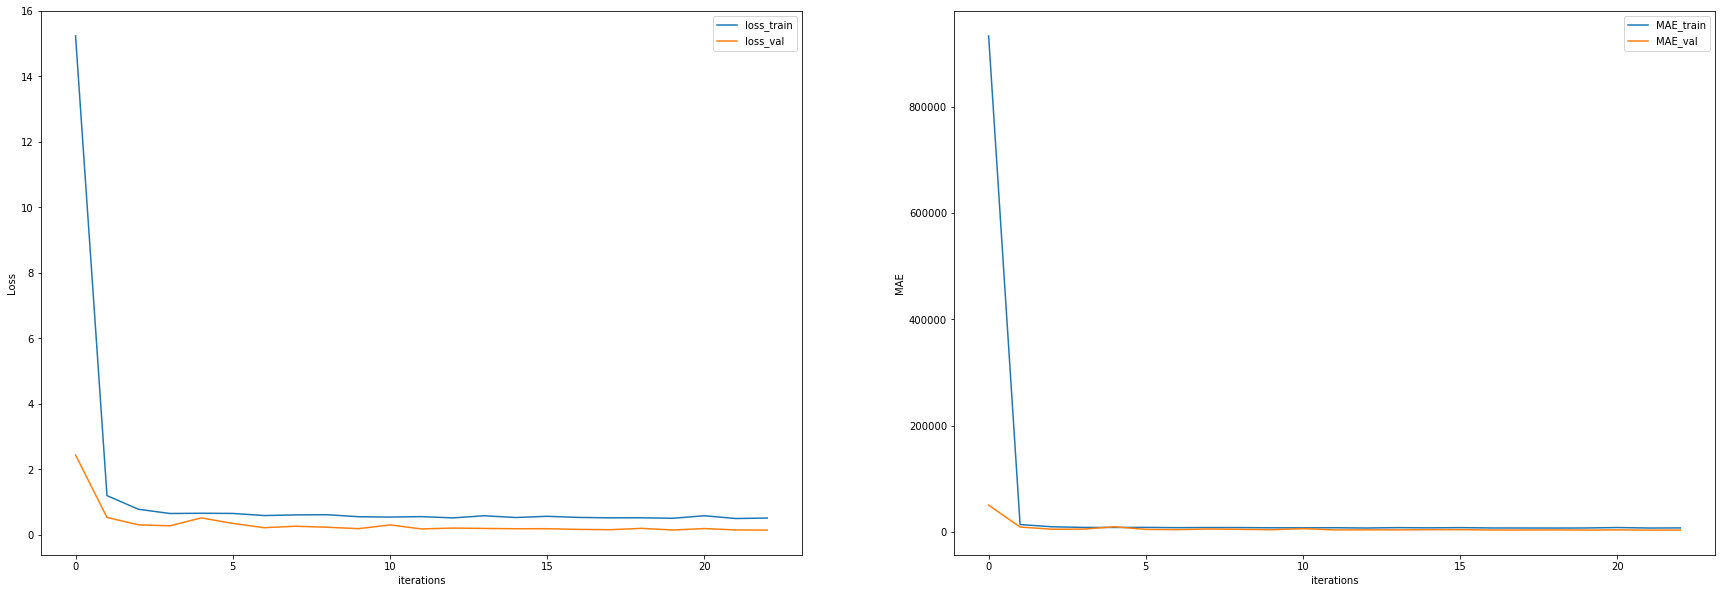

Training:
	Loss:	0.51148
	MAE:	7851.04165



Validation:
	Loss:	0.16311
	MAE:	3749.19960





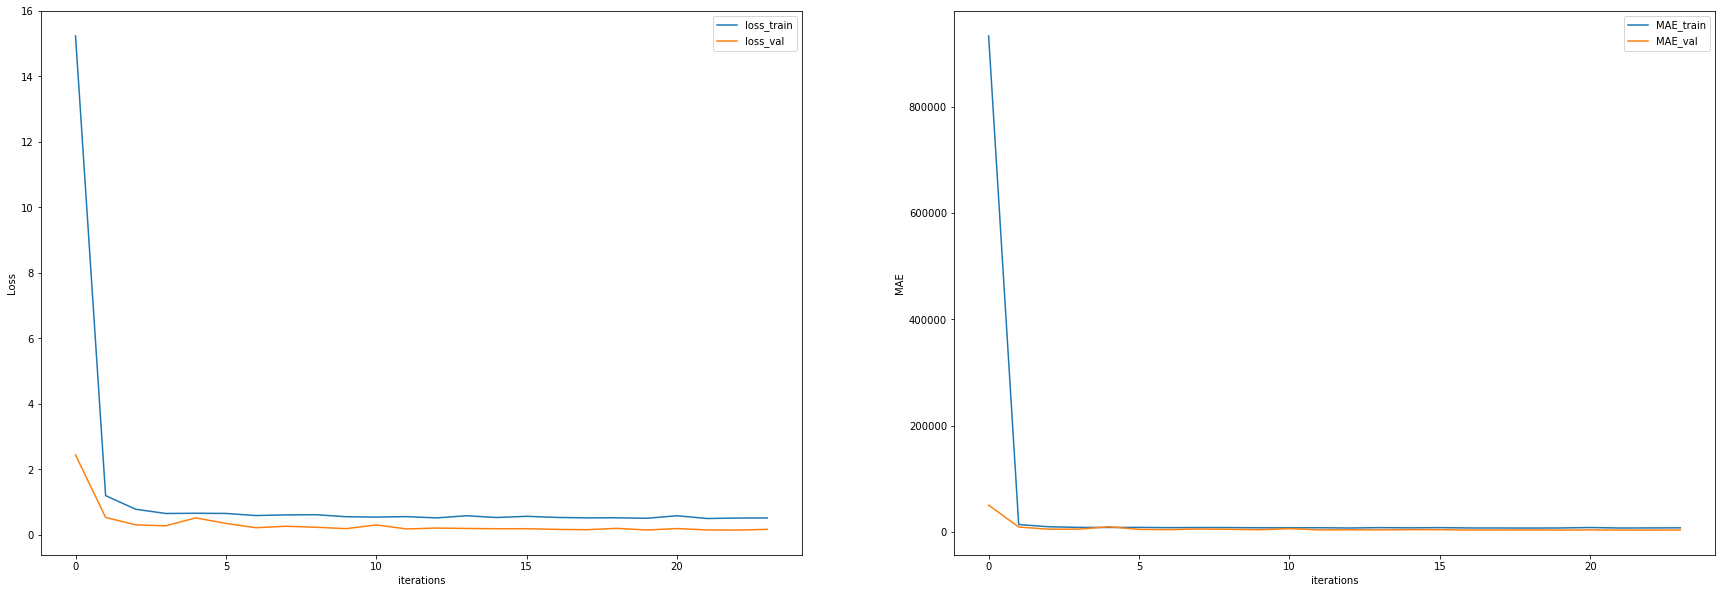

Training:
	Loss:	0.52671
	MAE:	7893.55911



Validation:
	Loss:	0.17224
	MAE:	3852.64751





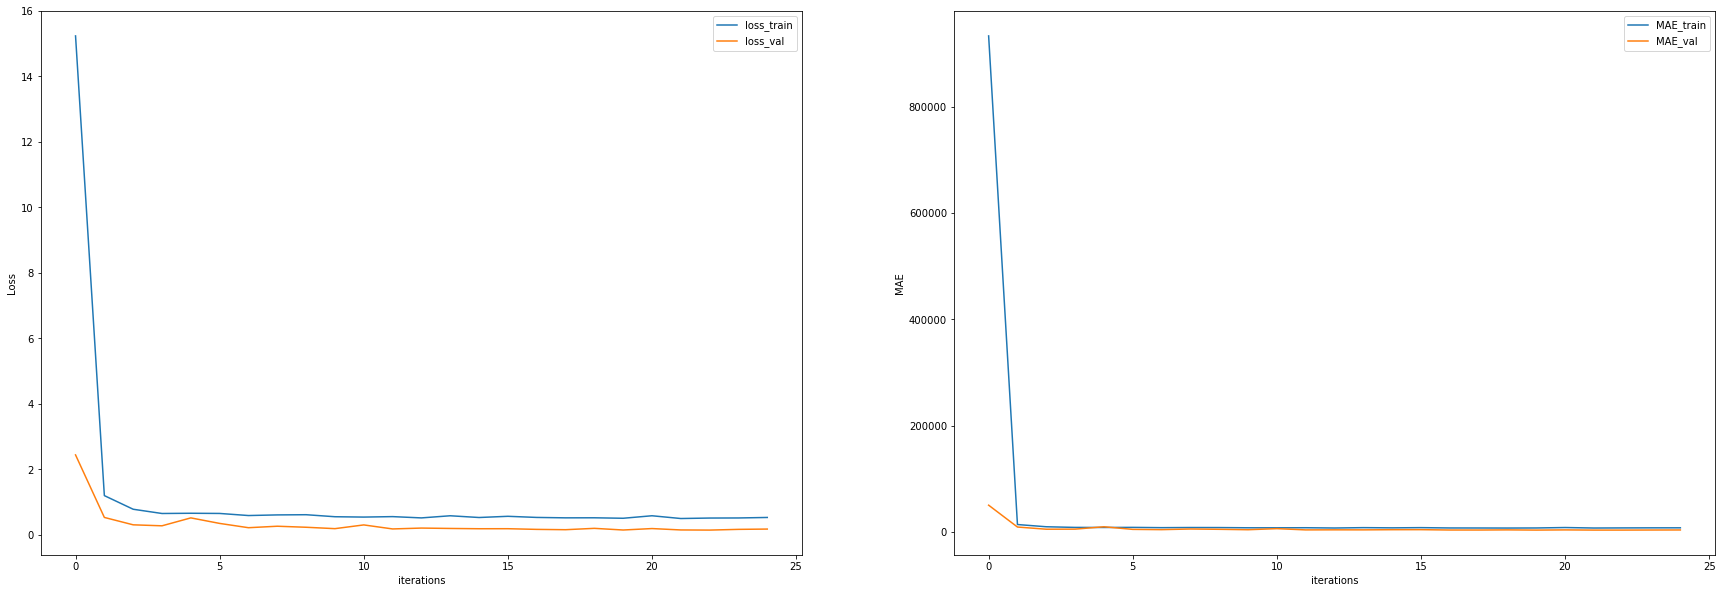

Training:
	Loss:	0.53370
	MAE:	7906.09912



Validation:
	Loss:	0.20229
	MAE:	4952.60391





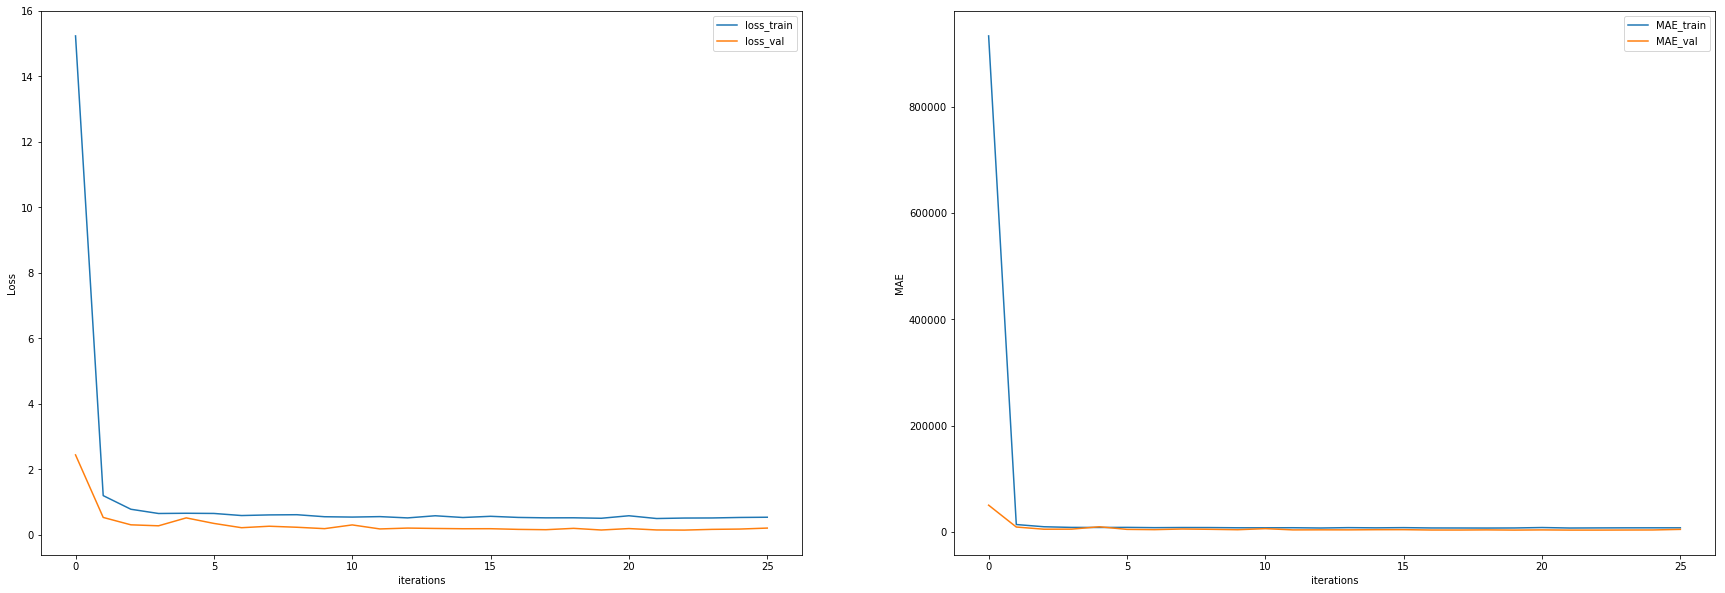

Training:
	Loss:	0.51483
	MAE:	7582.91037



Validation:
	Loss:	0.16521
	MAE:	3764.94083





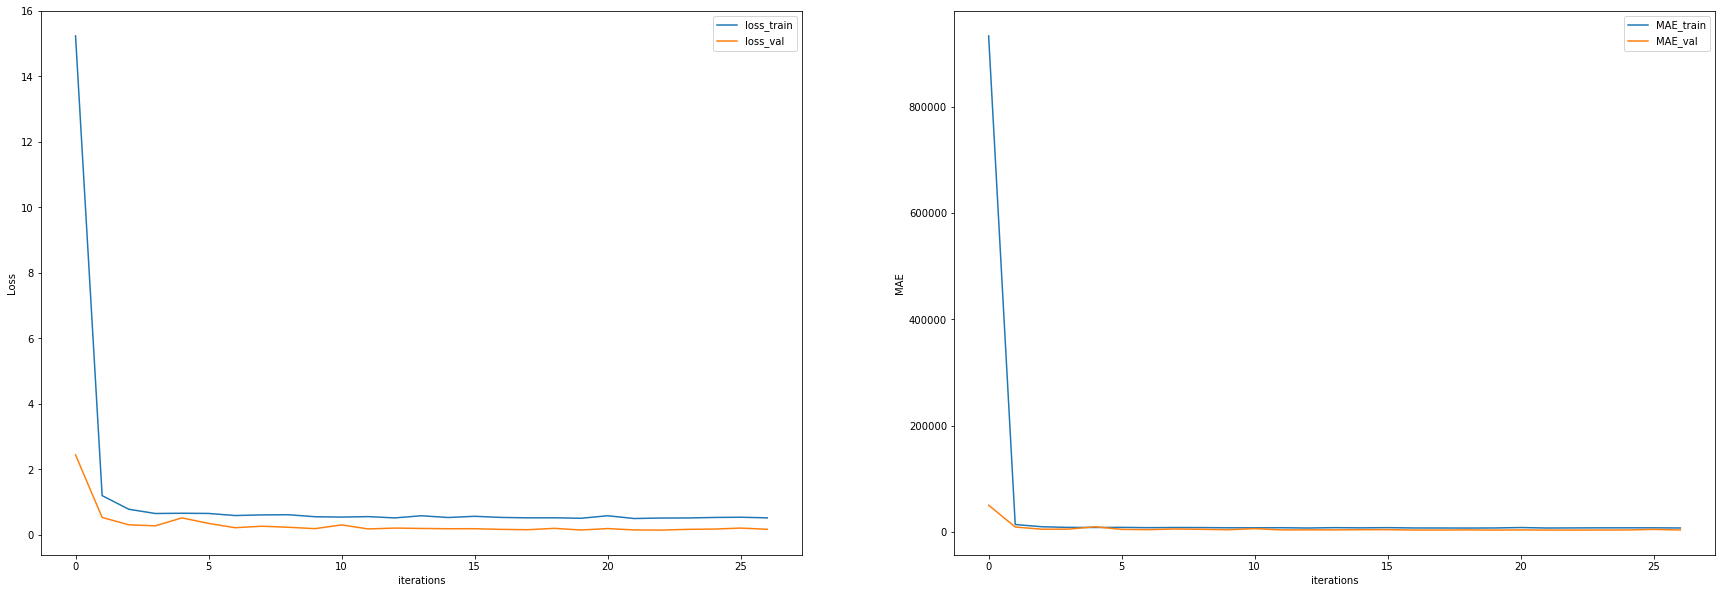

Evaluation loss stopped decreased less than 0.0 (-0.024516790755334972). Early stopping at epoch 26.


In [179]:
loss_train, loss_val, MAE_train, MAE_val = [], [], [], []


for epoch_i in tqdm_notebook(range(num_epochs)):
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()[0]
        train_mae += compute_mae(reference, prediction).data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()[0]
        val_mae += compute_mae(reference, prediction).data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
    loss_train.append(train_loss / train_batches)
    loss_val.append(val_loss / val_batches)
    MAE_train.append(train_mae / train_batches)
    MAE_val.append(val_mae / val_batches)
    
    plotting(loss_train, loss_val, MAE_train, MAE_val, epoch_i)
    
    if EarlyStopping_Smooth(loss=loss_val, epoch=epoch_i):
        break

In [180]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.16521
	MAE:	3764.94083





##### Видим ухудшение после  Early Stopping MAE 3739.61105 -> 3764.94083
##### Но разница не большая (всего 0.67%), но это позволило остановить обучение намного раньше (затратилось в 2 раза меньше времени) с 50 до 26 эпох